In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/NIR_Pepper/KC4.0")

In [1]:
import re
import datetime
import scipy
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.optimize import minimize_scalar
import scipy.linalg as linalg


from sys import stdout
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, Binarizer, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold , \
    cross_validate, StratifiedKFold


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./data/Data_NIR_Piperine.csv")
df.head(2)

901.398183  905.331226  909.259927  913.184288  917.104308  921.019987  \
0    0.796283    0.807090    0.806815    0.814125    0.810830    0.807256   
1    0.804850    0.802193    0.797433    0.790598    0.785346    0.778809   

   924.931325  930.13969  934.0409  937.937768  ...  1676.942091  1679.898431  \
0    0.805796   0.811505  0.811614    0.811576  ...     0.084266     0.069633   
1    0.777123   0.774463  0.770682    0.766470  ...     0.110003     0.100550   

   1682.85043  1685.798089  1688.741406  1691.680383  1694.615018  \
0    0.067933     0.075654     0.082042     0.091143     0.094711   
1    0.101611     0.113941     0.122556     0.137870     0.146910   

   1697.545313  1701.44562  Peperine  
0     0.097288    0.127496    5.6150  
1     0.150071    0.173392    3.8333  

[2 rows x 229 columns]

In [3]:
df.columns

Index(['901.398183', '905.331226', '909.259927', '913.184288', '917.104308',
       '921.019987', '924.931325', '930.13969', '934.0409', '937.937768',
       ...
       '1676.942091', '1679.898431', '1682.85043', '1685.798089',
       '1688.741406', '1691.680383', '1694.615018', '1697.545313',
       '1701.44562', 'Peperine'],
      dtype='object', length=229)

In [4]:
wavelength = df.columns[:-1]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

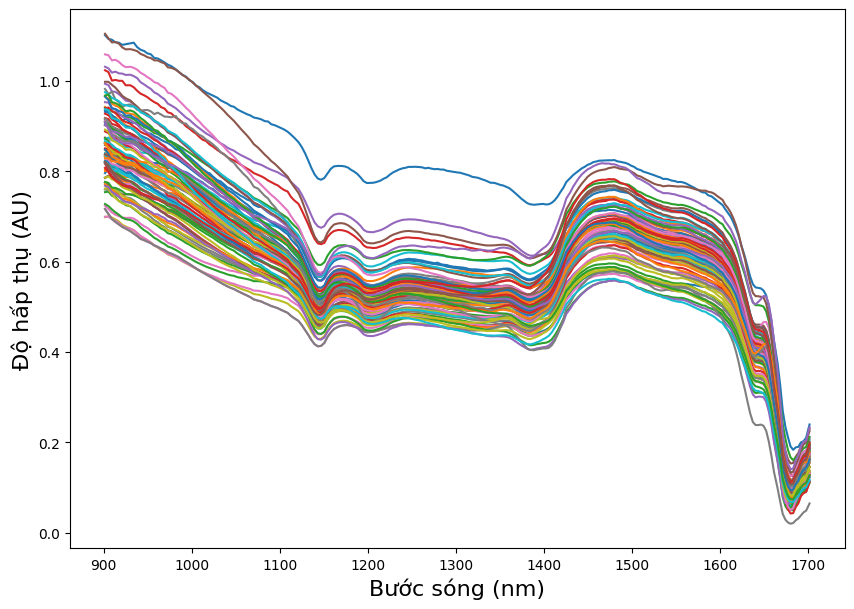

In [5]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(0,len(df)):
    ax.plot(wavelength,df.iloc[i,:-1])

#ax.set_title('Tổng hợp kết quả tiêu', fontsize=20)
ax.set_xlabel('Bước sóng (nm)', fontsize=16)
ax.set_ylabel('Độ hấp thụ (AU)', fontsize=16)
#ax.set_ylim([-0.5, 2.5])
plt.show()

In [6]:
from pypls import *

In [30]:
X = df.iloc[:,:-1].values
y = df.iloc[:, -1]

In [41]:
X_SNV = ZS4Data().fit_transform(X)
fig, axes = plt.subplots(1,1,figsize=(15,10))
for j in range(0,len(X_SNV)):
    axes.plot(wavelength,X_SNV[j,:])
    axes.set_xlabel('Bước sóng (nm)', fontsize=12)
    axes.set_ylabel('Độ hấp thụ (AU)', fontsize=12)
plt.show()

TypeError: msc_list() missing 1 required positional argument: 'spec_list'

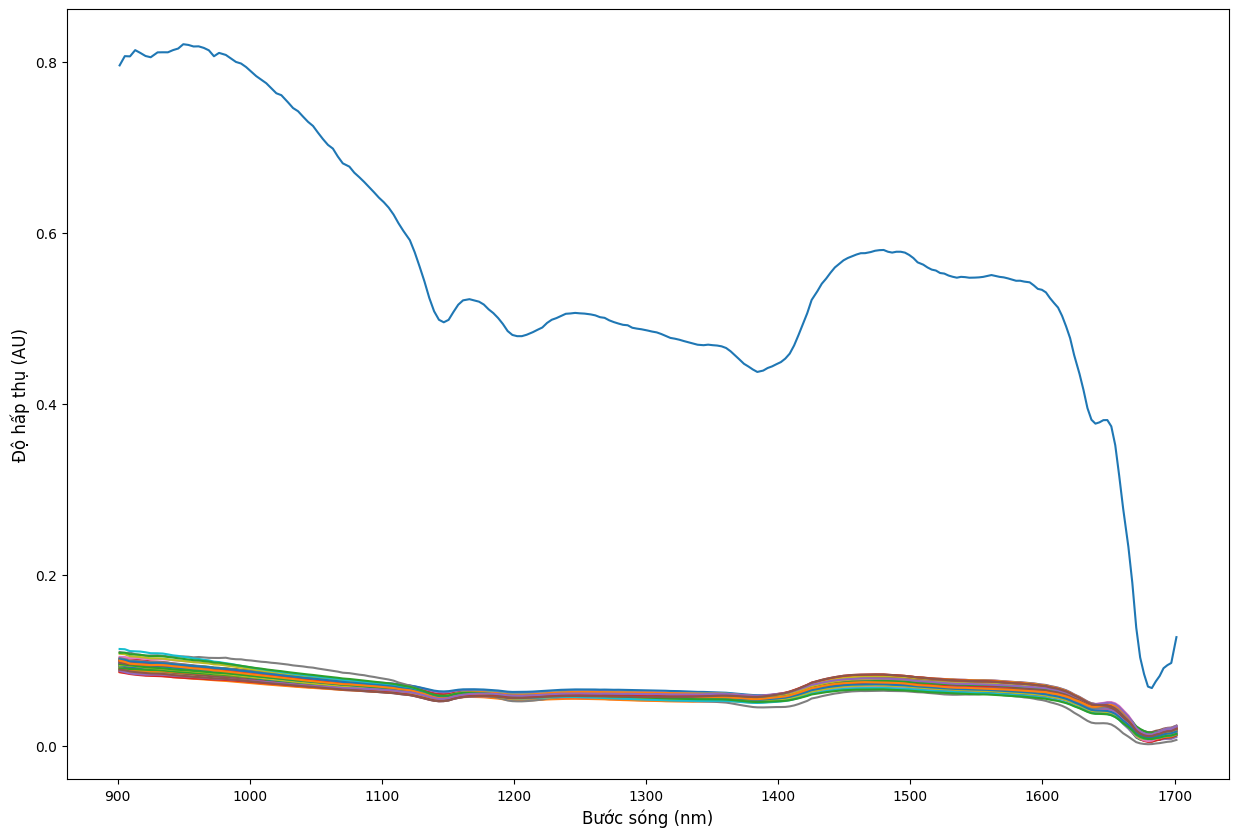

In [42]:
msc_list(X)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(15,10))
for i, ax in zip(range(len(name_preprocess)), axes.flatten()):
    for j in range(0,len(X1[i])):
        ax.plot(wavelength,X1[i][j,:])

    ax.set_title('{}'.format(name_preprocess[i]), fontsize=14)
    ax.set_xlabel('Bước sóng (nm)', fontsize=12)
    ax.set_ylabel('Độ hấp thụ (AU)', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
def snv(input_data):
    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return output_data


def msc(input_data1, reference=None):
    input_data = input_data1
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate it from the mean
    if reference is None:
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference

    # Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]

    return data_msc

def detrend(input_data):
    return tsa.detrend(input_data, order=1, axis=0)

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def Perform_data(data1):
    data = data1
    ## Settings for the smooth derivatives using a Savitsky-Golay filter
    w = 13 ## Sav.Gol window size
    p = 2  ## Sav.Gol polynomial degree
    convert_data = np.concatenate((data, snv(data), msc(data), \
                                  savgol_filter(data, w, polyorder = p, deriv=1), savgol_filter(data, w, polyorder = p, deriv=2)), axis = 1)
    return convert_data

In [10]:
X = df.iloc[:,:-1].values
y = df.iloc[:, -1]

In [ ]:
X_SNV = snv(X)
w = 13 ## Sav.Gol window size
p = 2  ## Sav.Gol polynomial degree
X_SG1= savgol_filter(X, w, polyorder = p, deriv=1)
X_SG2= savgol_filter(X, w, polyorder = p, deriv=2)
X_MSC = msc(X)


In [ ]:
name_preprocess = ['RAW', 'SNV', 'MSC', 'SG1', 'SG2']
name_att = ['DoAm', 'TroTong', 'Peperine', 'TinhDau']
X1 = [X, X_SNV, X_MSC, X_SG1, X_SG2]

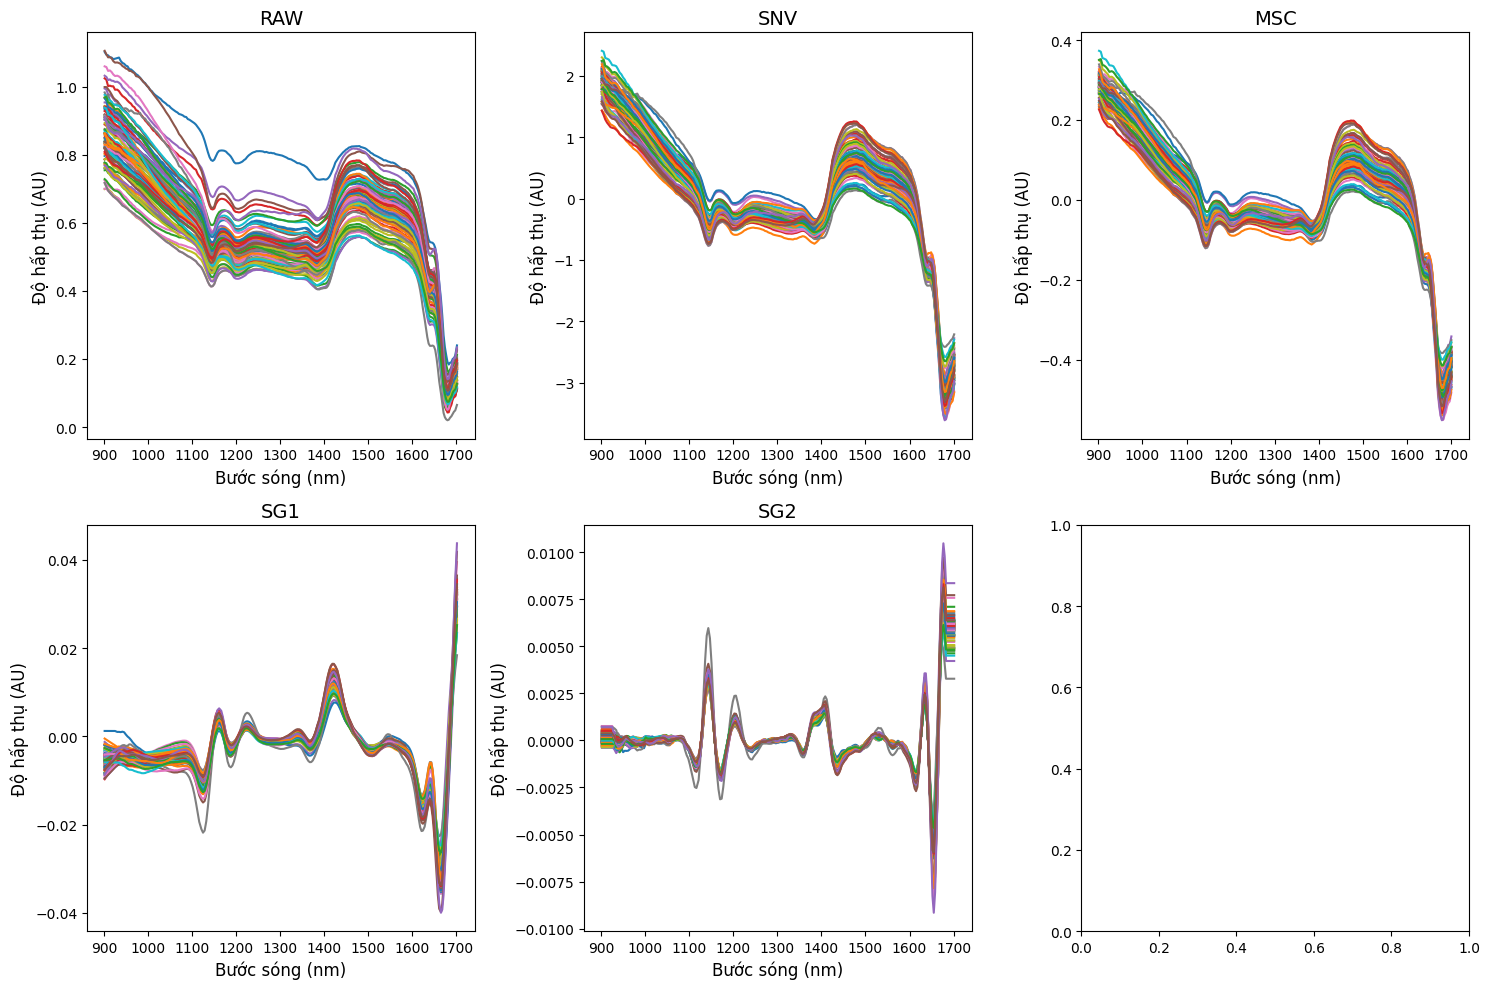

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(15,10))
for i, ax in zip(range(len(name_preprocess)), axes.flatten()):
    for j in range(0,len(X1[i])):
        ax.plot(wavelength,X1[i][j,:])

    ax.set_title('{}'.format(name_preprocess[i]), fontsize=14)
    ax.set_xlabel('Bước sóng (nm)', fontsize=12)
    ax.set_ylabel('Độ hấp thụ (AU)', fontsize=12)
plt.tight_layout()
plt.show()

#### PLS

In [ ]:
# define a function to evaluate pls
def pls_evaluate_num_comp(X, y, num_comp):
    pls = PLSRegression(n_components=num_comp)
    y_cv = cross_val_predict(pls, X, y, cv=5)
    mse = mean_squared_error(y_cv, y)
    r2 = r2_score(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    return (y_cv, mse, r2, rpd)

In [ ]:
# Try optimize the number of components (without variable selection) => we will use X1
def pls_evaluate_num_comps(X, y, num_comps):
    mses = []
    r2s = []
    rpds = []
    for num_comp in num_comps:
        _, mse, r2, rpd = pls_evaluate_num_comp(X, y, num_comp)
        mses.append(mse)
        r2s.append(r2)
        rpds.append(rpd)
    return (mses, r2s, rpds)

In [ ]:
def plot_metric(scores, objective, yLabel):
    with plt.style.context('seaborn-notebook'):
        plt.plot(num_comps, scores, '-o', color='blue')
        idx = np.argmin(scores) if objective == 'min' else np.argmax(scores)
        plt.plot(num_comps[idx], scores[idx], 'P', color='red', ms=10)
        plt.xlabel("Số lượng thành phần chính", fontsize=16)
        plt.ylabel(yLabel, fontsize=16)
    plt.show()
    return (num_comps[idx], scores[idx])

In [ ]:
def pls_evaluate_plot_num_comps(X, y, num_comps):
    mses, r2s, rpds = pls_evaluate_num_comps(X, y, num_comps)
    # Plot mses
    num_comp, mse = plot_metric(mses, 'min', 'MSE')
    print(f'The best mse is {mse} with {num_comp} PLS components')
    # Plot r2s
    num_comp, r2  = plot_metric(r2s, 'max', 'R2')
    print(f'The best r2 is {r2} with {num_comp} PLS components')
    # Plot rpds
    num_comp, rpd = plot_metric(rpds, 'max', 'RPD')
    print(f'The best RPD is {rpd} with {num_comp} PLS components')

RAW


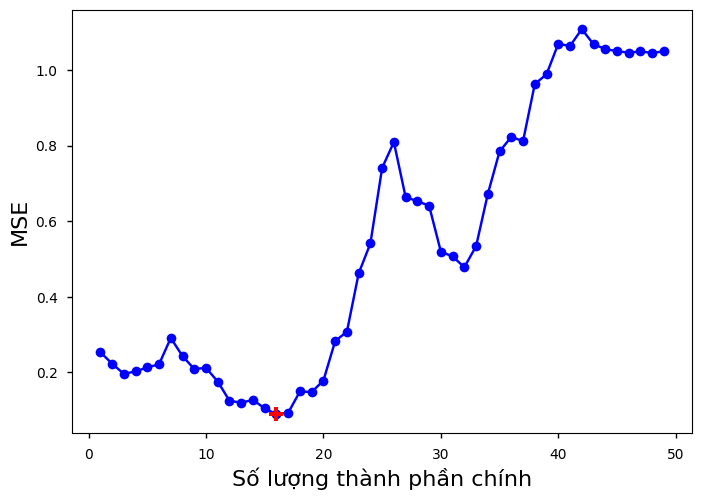

The best mse is 0.08961961343829505 with 16 PLS components


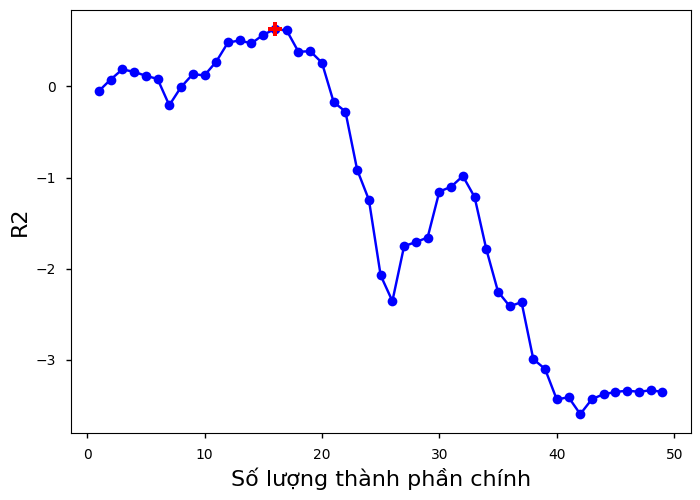

The best r2 is 0.6286387193621855 with 16 PLS components


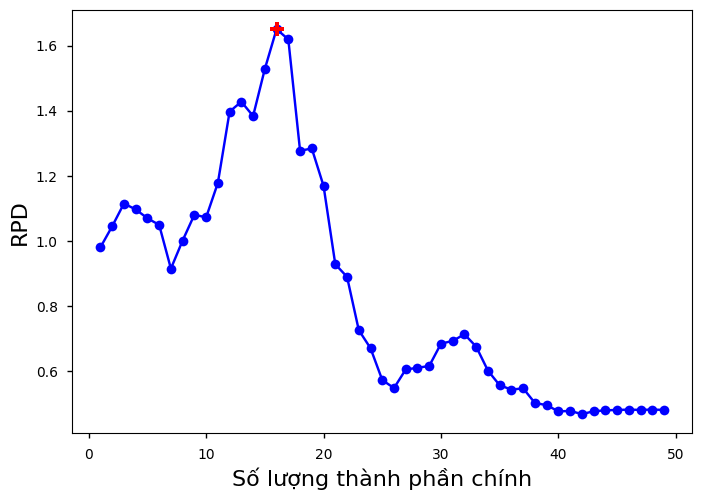

The best RPD is 1.6505985238398375 with 16 PLS components
SNV


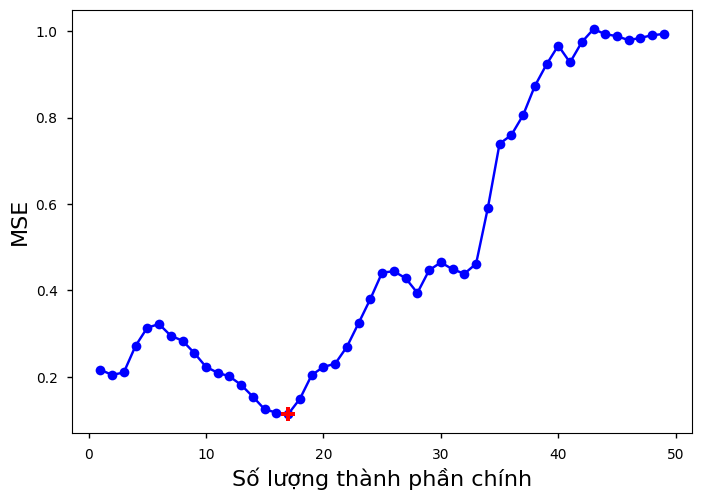

The best mse is 0.11382745017828404 with 17 PLS components


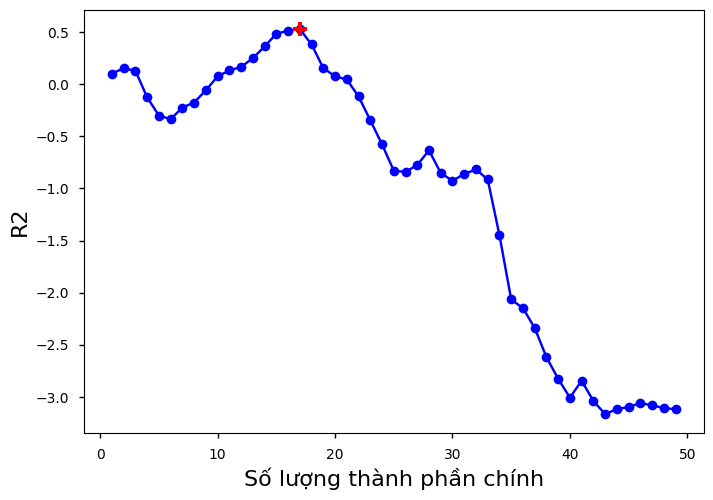

The best r2 is 0.5283274938577022 with 17 PLS components


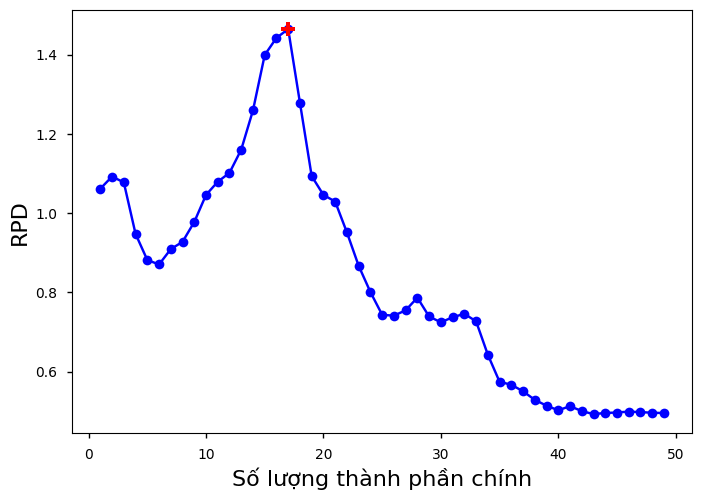

The best RPD is 1.4646015243633332 with 17 PLS components
MSC


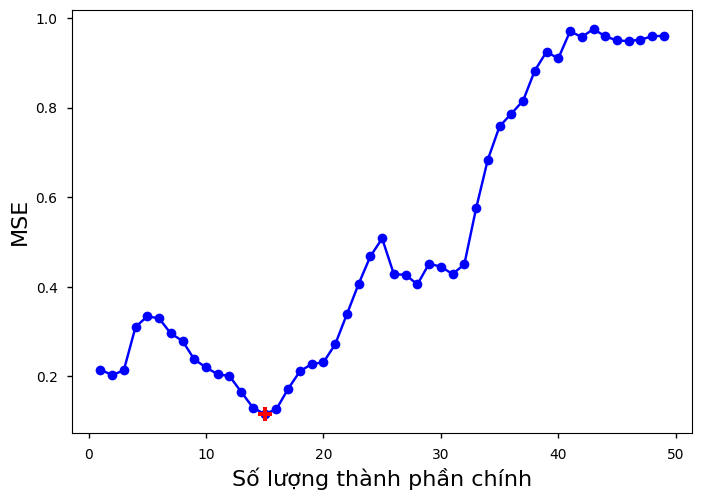

The best mse is 0.11599637427913766 with 15 PLS components


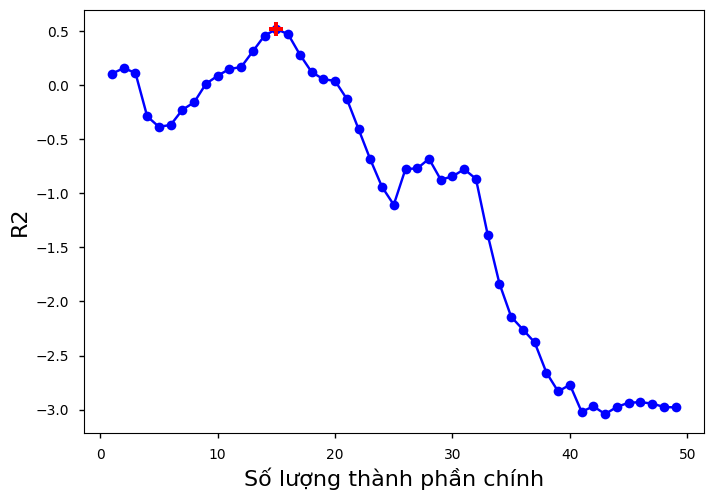

The best r2 is 0.5193400144344196 with 15 PLS components


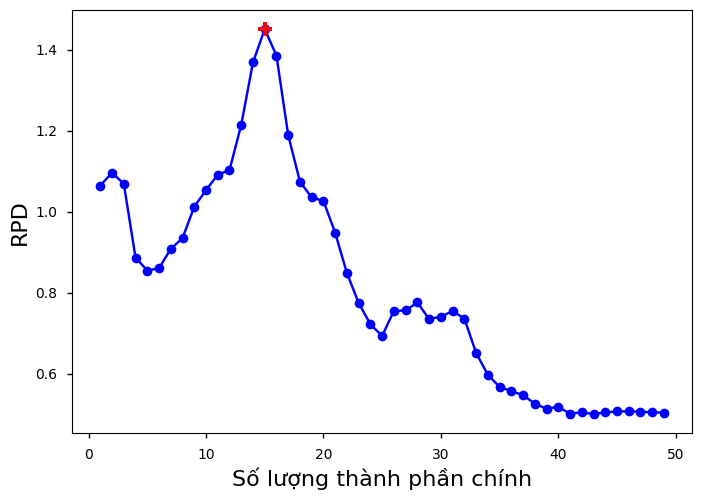

The best RPD is 1.4508442010852003 with 15 PLS components
SG1


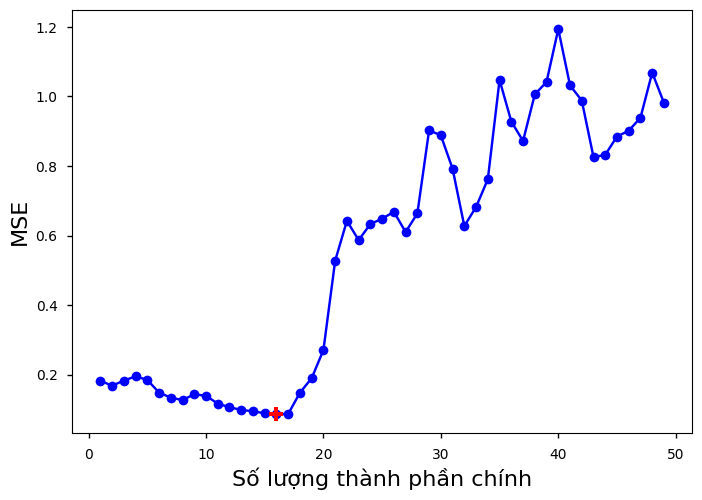

The best mse is 0.0866599488194925 with 16 PLS components


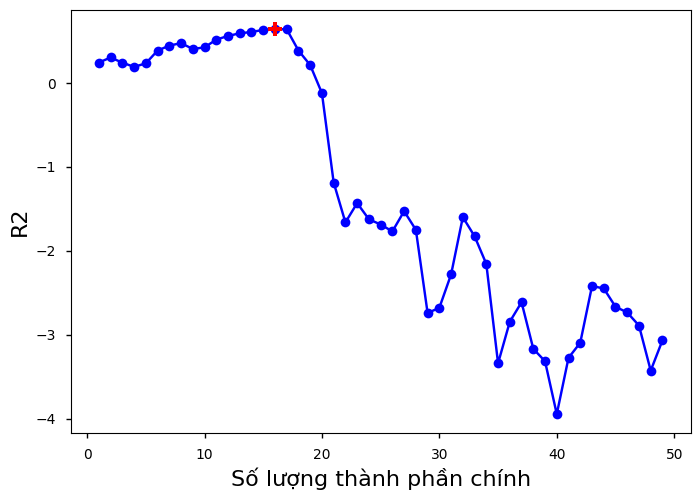

The best r2 is 0.6409028298724779 with 16 PLS components


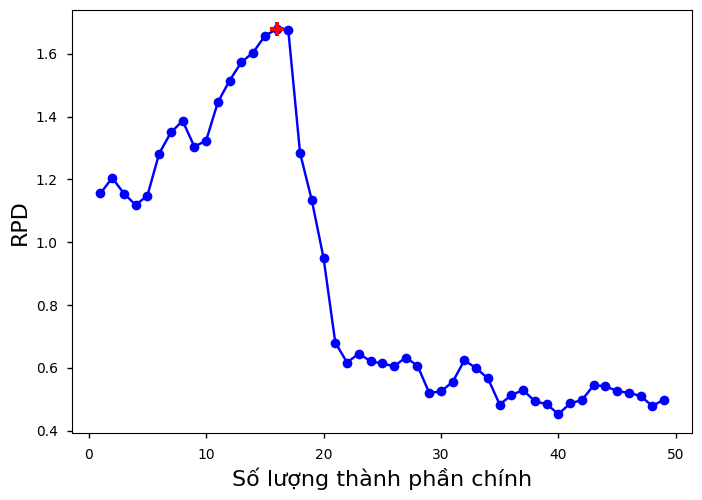

The best RPD is 1.6785480251959208 with 16 PLS components
SG2


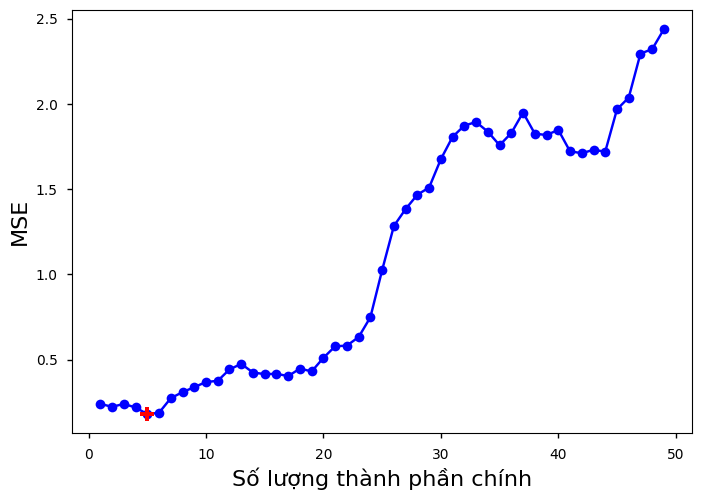

The best mse is 0.17989067739602918 with 5 PLS components


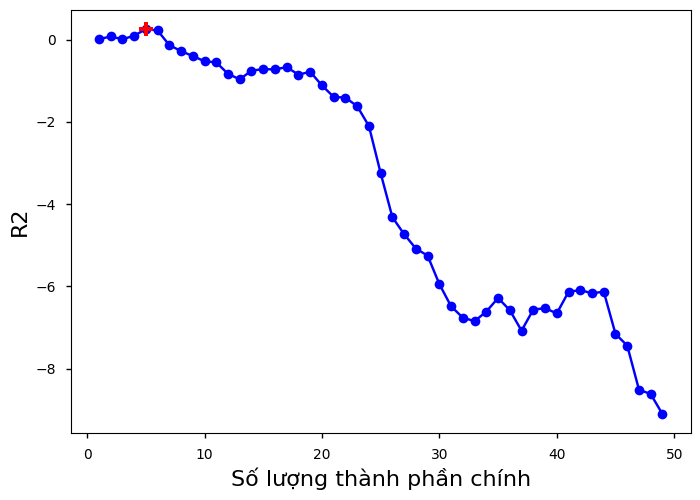

The best r2 is 0.25457799058027 with 5 PLS components


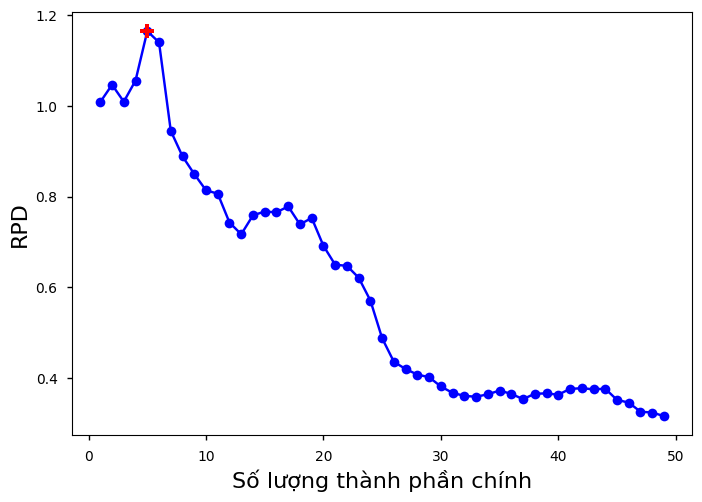

The best RPD is 1.16503415312154 with 5 PLS components


In [ ]:
for i in range(len(name_preprocess)):
    print(name_preprocess[i])
    # test with the first 15 components and choose the best for absorbance.
    num_comps = np.arange(1, 50)
    pls_evaluate_plot_num_comps(X1[i], y, num_comps)

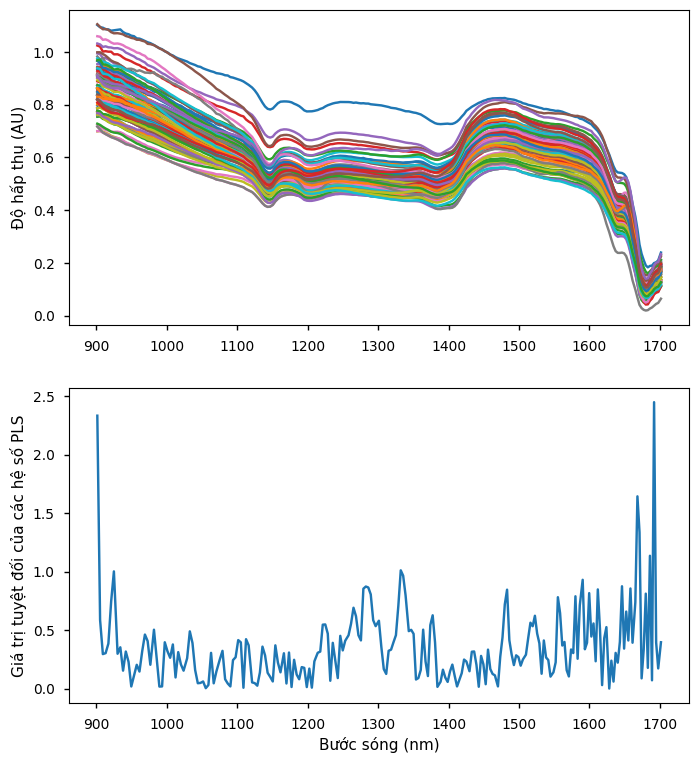

In [ ]:
# Define the PLS regression object
pls = PLSRegression(n_components=16)
# Fit data
pls.fit(X1[0], y)

# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('seaborn-notebook')):
    ax1 = plt.subplot(211)
    plt.plot(wavelength, X1[0].T)
    plt.ylabel('Độ hấp thụ (AU)')

    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wavelength, np.abs(pls.coef_[:,0]))
    plt.xlabel('Bước sóng (nm)')
    plt.ylabel('Giá trị tuyệt đối của các hệ số PLS')

    plt.show()

R2 calib: 0.881
R2 CV: 0.629
MSE calib: 0.029
MSE CV: 0.090


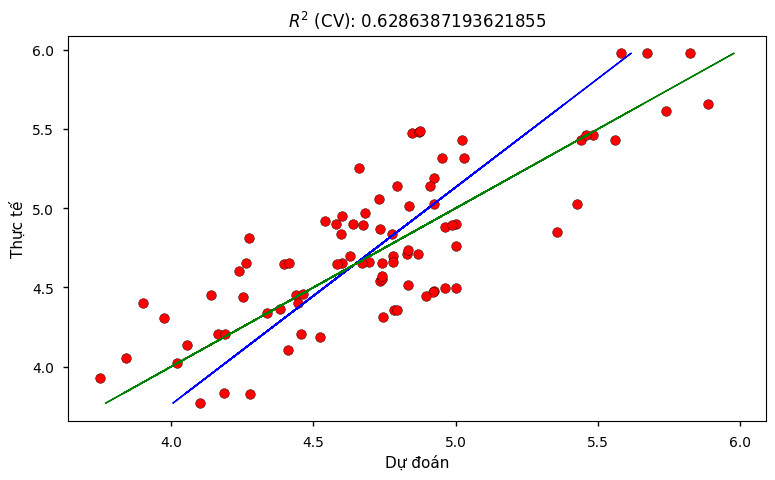

In [ ]:
simple_pls_cv(X1[0], y, 16)

In [ ]:
def pls_evaluate_and_plot_num_comp(X, y, num_comp):
    # Evaluate the result with first three components
    y_cv, mse, r2, rpd = pls_evaluate_num_comp(X, y, num_comp)
    # Print the result
    print('MSE: %0.4f' % (mse))
    print('R2: %0.4f' % (r2))
    print('RPD: %0.4f' % (rpd))
    # plot the regression
    p = np.polyfit(y, y_cv, deg=1)
    with plt.style.context('ggplot'):
        plt.figure(figsize=(6, 6))
        plt.scatter(y, y_cv, color='red', edgecolors='black')
        plt.plot(y, y, '-g', label='Expectation')
        plt.plot(y, np.polyval(p, y),'-b', label='Prediction regression')
        plt.legend()
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.plot()
    return (y_cv, mse, r2, rpd)

In [ ]:
# Test for absorbance at its best number of components (6)
_ = pls_evaluate_and_plot_num_comp(X_SNV, y1, 2)

In [ ]:
def pls_variable_selection(X, y, max_comp):

    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))

    # Loop over the number of PLS components
    for i in range(max_comp):

        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)

        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))

        # Sort spectra accordingly
        Xc = X[:,sorted_ind]

        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):

            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)

            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)

            mse[i,j] = mean_squared_error(y, y_cv)

        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))

    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()


    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)

    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))

    Xc = X[:,sorted_ind]

    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)


def simple_pls_cv(X, y, n_comp):

    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_c = pls.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=5)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression

    z = np.polyfit(y, y_cv, 1)
    with plt.style.context(('seaborn-notebook')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_cv, y, c='red', edgecolors='k')
        ax.plot(z[1]+z[0]*y, y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('')
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Dự đoán')
        plt.ylabel('Thực tế')

        plt.show()

## RAW

100% completed
Optimised number of PLS components:  26
Wavelengths to be discarded  163
Optimised MSEP  0.0405049132515219

R2 calib: 0.965
R2 CV: 0.832
MSE calib: 0.009
MSE CV: 0.041


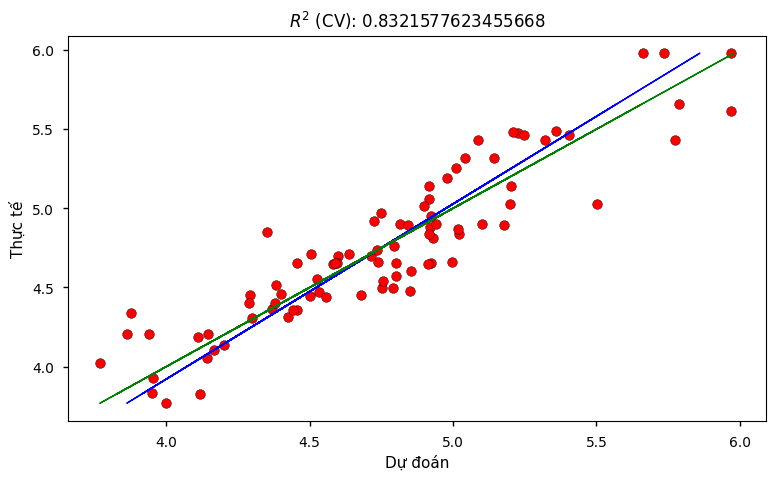

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1[0],y, 30)
simple_pls_cv(opt_Xc, y, ncomp)

## SNV

100% completed
Optimised number of PLS components:  29
Wavelengths to be discarded  172
Optimised MSEP  0.03965607799165644

R2 calib: 0.980
R2 CV: 0.836
MSE calib: 0.005
MSE CV: 0.040


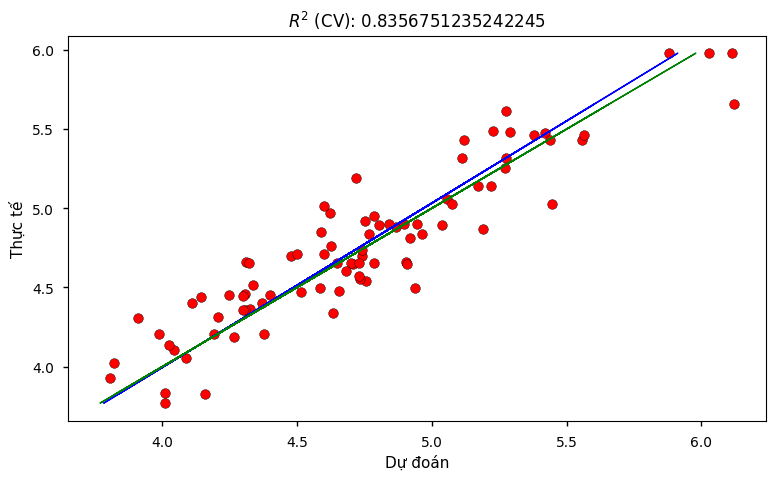

In [ ]:
opt_Xc_SNV, ncomp_SNV, wav_SNV, sorted_ind_SNV = pls_variable_selection(X1[1],y, 30)
simple_pls_cv(opt_Xc_SNV, y, ncomp_SNV)

## MSC

100% completed
Optimised number of PLS components:  29
Wavelengths to be discarded  164
Optimised MSEP  0.036084157456014655

R2 calib: 0.980
R2 CV: 0.850
MSE calib: 0.005
MSE CV: 0.036


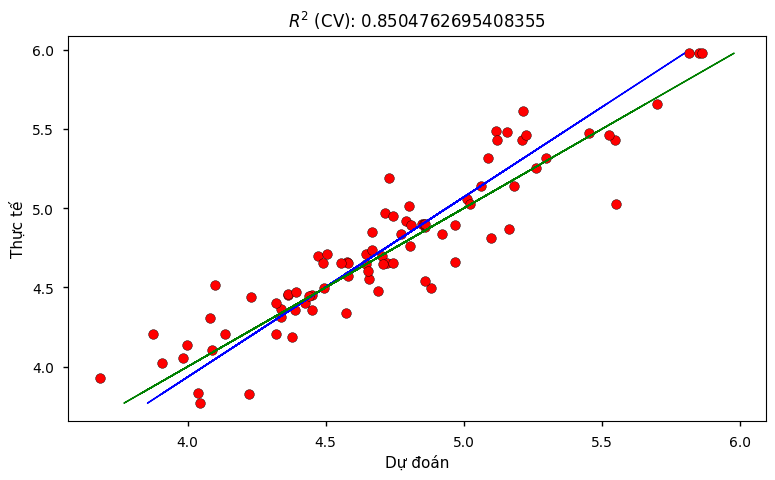

In [ ]:
opt_Xc_MSC, ncomp_MSC, wav_MSC, sorted_ind_MSC = pls_variable_selection(X1[2],y, 30)
simple_pls_cv(opt_Xc_MSC, y, ncomp_MSC)

100% completed
Optimised number of PLS components:  15
Wavelengths to be discarded  149
Optimised MSEP  0.06351195809282104

R2 calib: 0.875
R2 CV: 0.737
MSE calib: 0.030
MSE CV: 0.064


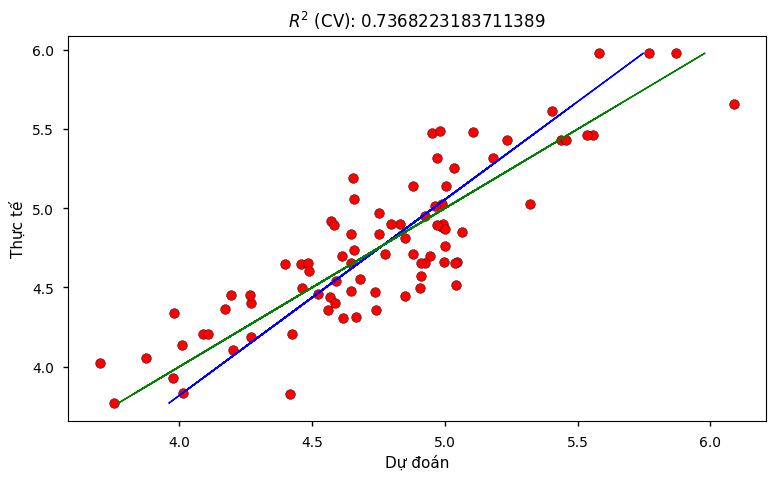

In [ ]:
opt_Xc_SG1, ncomp_SG1, wav_SG1, sorted_ind_SG1 = pls_variable_selection(X1[3],y, 30)
simple_pls_cv(opt_Xc_SG1, y, ncomp_SG1)

100% completed
Optimised number of PLS components:  16
Wavelengths to be discarded  192
Optimised MSEP  0.06669001809683944

R2 calib: 0.895
R2 CV: 0.724
MSE calib: 0.025
MSE CV: 0.067


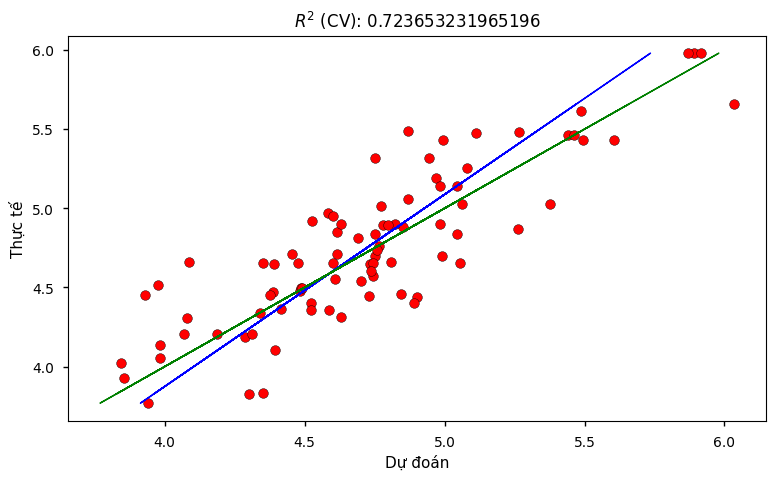

In [ ]:
opt_Xc_SG2, ncomp_SG2, wav_SG2, sorted_ind_SG2 = pls_variable_selection(X1[4],y, 30)
simple_pls_cv(opt_Xc_SG2, y, ncomp_SG2)

In [ ]:
dictionary_data = {"a": 1, "b": 2}

a_file = open("data.pkl", "wb")
pickle.dump(dictionary_data, a_file)
a_file.close()


In [6]:
import pickle

In [ ]:
def save_para_model(name, opt_Xc, ncomp, wav, sorted_ind):
    dictionary_data = {"opt_X": opt_Xc,
                    "ncomp": ncomp,
                    "wav": wav,
                    "sorted_ind": sorted_ind
                    }
    a_file = open("./data/{}.pkl".format(name), "wb")
    pickle.dump(dictionary_data, a_file)
    a_file.close()


In [ ]:
save_para_model("RAW_parameter", opt_Xc, ncomp, wav, sorted_ind)
save_para_model("SNV_parameter", opt_Xc_SNV, ncomp_SNV, wav_SNV, sorted_ind_SNV)
save_para_model("MSC_parameter", opt_Xc_MSC, ncomp_MSC, wav_MSC, sorted_ind_MSC)
save_para_model("SG1_parameter", opt_Xc_SG1, ncomp_SG1, wav_SG1, sorted_ind_SG1)
save_para_model("SG2_parameter", opt_Xc_SG2, ncomp_SG2, wav_SG2, sorted_ind_SG2)

In [ ]:
output['opt_X'].shape

(86, 65)

In [7]:
a_file = open("./data/MSC_parameter.pkl", "rb")
output = pickle.load(a_file)
print(output)

{'opt_X': array([[-0.04649363, -0.08547766,  0.007606  , ...,  0.03389344,
        -0.08145788, -0.43408728],
       [-0.0577236 , -0.0322455 ,  0.09327126, ...,  0.1472105 ,
        -0.06205163, -0.47632957],
       [-0.03227011, -0.04235033,  0.04685656, ...,  0.09346668,
        -0.09705699, -0.46890045],
       ...,
       [-0.06791806, -0.01882177,  0.1170813 , ...,  0.19024743,
        -0.05175135, -0.48454597],
       [-0.0485185 , -0.02832935,  0.07952463, ...,  0.14976701,
        -0.0676644 , -0.49806628],
       [-0.07022813, -0.02133184,  0.11319528, ...,  0.18379488,
        -0.04940439, -0.4721814 ]]), 'ncomp': 29, 'wav': 164, 'sorted_ind': array([ 79,  17, 104,  46, 169, 121, 219,   1, 200,  45,  22, 136,  76,
       119, 154, 187,  51,  73, 182, 125, 153, 144, 204, 120,  69,  80,
       124, 109,   4, 142, 174, 212,  71, 168, 143, 170,   3,  65, 183,
        59,   8,   2,  99, 213, 127, 184,   9, 131,   0, 140,  41,  53,
       189,  56,  82, 101, 220,  31,  72,  37,  5

In [8]:
sorted_ind2 = wavelength[output['sorted_ind']][output['wav']:].astype('int')
sorted_ind2

array([1191, 1405, 1558, 1551, 1032, 1505, 1628,  961, 1139, 1590,  972,
       1380, 1525, 1476, 1075, 1661, 1479, 1452, 1249, 1020, 1232, 1593,
       1388, 1599, 1634,  930, 1258, 1649, 1611, 1246, 1499, 1221, 1090,
       1596, 1384, 1694, 1425, 1228, 1395, 1682,  976, 1685, 1235, 1532,
       1602,  949, 1051,  924,  993, 1509, 1643, 1697, 1640, 1605, 1202,
       1004, 1620, 1483, 1673, 1652, 1489, 1486, 1623, 1691])

In [11]:
# Create and fit the PLS regression model
pls_model = PLSRegression(n_components=output['ncomp'])
pls_model.fit(output['opt_X'], y)

# Extract the model coefficients
coefficients = pls_model.coef_

# Formulate the equation
intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "
for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "
equation = equation[:-3]  # Remove the last ' + ' from the equation

print(equation)

y = 4.759 -0.935 * X_1191 -2.202 * X_1405 -1.97 * X_1558 -7.051 * X_1551 -4.986 * X_1032 -2.458 * X_1505 -2.545 * X_1628  + 2.747 * X_961 -0.759 * X_1139  + 6.355 * X_1590 -5.028 * X_972  + 2.107 * X_1380  + 1.714 * X_1525 -5.505 * X_1476  + 2.582 * X_1075  + 2.456 * X_1661 -2.037 * X_1479 -4.463 * X_1452 -3.898 * X_1249 -3.962 * X_1020  + 2.672 * X_1232  + 1.592 * X_1593 -2.72 * X_1388  + 3.69 * X_1599  + 2.525 * X_1634  + 1.574 * X_930 -5.894 * X_1258  + 0.074 * X_1649  + 1.54 * X_1611 -1.38 * X_1246  + 0.692 * X_1499 -1.053 * X_1221 -5.631 * X_1090 -0.674 * X_1596 -3.049 * X_1384 -2.788 * X_1694 -1.514 * X_1425  + 1.844 * X_1228  + 4.634 * X_1395  + 0.262 * X_1682  + 1.164 * X_976 -3.738 * X_1685  + 5.489 * X_1235  + 2.075 * X_1532 -11.774 * X_1602 -1.764 * X_949  + 5.423 * X_1051 -1.745 * X_924 -3.46 * X_993 -7.292 * X_1509 -1.0 * X_1643 -3.846 * X_1697  + 2.149 * X_1640  + 5.532 * X_1605 -3.065 * X_1202  + 5.57 * X_1004 -0.549 * X_1620  + 4.928 * X_1483 -2.298 * X_1673 -4.427 * X_

In [ ]:
sorted_ind2 = output['sorted_ind'][output['wav']:]
len(sorted_ind2)


64

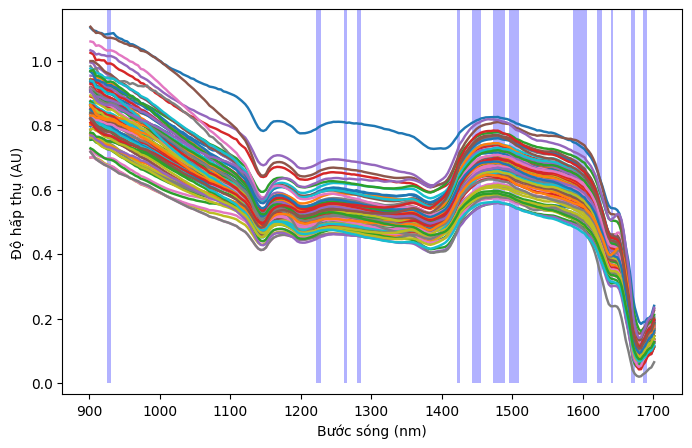

In [ ]:
ix = np.in1d(wavelength.ravel(), wavelength[sorted_ind][:wav])
import matplotlib.collections as collections

# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(8,5))
with plt.style.context(('seaborn-notebook')):
    ax.plot(wavelength, X1[0].T)
    plt.ylabel('Độ hấp thụ (AU)')
    plt.xlabel('Bước sóng (nm)')

collection = collections.BrokenBarHCollection.span_where(
    wavelength, ymin=0, ymax=2, where=ix == False, facecolor='blue', alpha=0.3)
ax.add_collection(collection)

plt.show()

In [12]:
from sklearn.utils import resample



# List to store predictions from each bootstrap iteration
bootstrap_predictions = []
# Number of bootstrap iterations
n_iterations = 1000
# Bootstrap loop
for _ in range(n_iterations):
    # Bootstrap sample
    X_boot, y_boot = resample(output['opt_X'], y)

    # PLS regression model
    pls_model = PLSRegression(n_components=output['ncomp'])
    pls_model.fit(X_boot, y_boot)

    # Make predictions on the original dataset
    y_pred = pls_model.predict(output['opt_X'])

    # Store predictions from the current iteration
    bootstrap_predictions.append(y_pred)

# Calculate mean and standard deviation of the bootstrap predictions
bootstrap_predictions = np.array(bootstrap_predictions)
mean_predictions = np.mean(bootstrap_predictions, axis=0)
std_predictions = np.std(bootstrap_predictions, axis=0)

# Calculate confidence interval (95% confidence level)
confidence_interval = 1.96 * std_predictions

# Calculate mean squared error (optional)
mse = mean_squared_error(y, mean_predictions)
r2 = r2_score(y, mean_predictions)



In [26]:
matrix1 = pd.DataFrame(bootstrap_predictions.reshape(1000,86))


0         1         2         3         4         5         6   \
0  5.626502  4.121220  4.465511  5.046234  4.193404  4.466849  3.780861   
1  5.621497  3.962208  4.507198  4.751135  4.160142  4.493097  3.758415   
2  5.191393  3.836470  4.657291  4.978981  4.126777  4.068041  3.889725   
3  5.618452  3.840929  4.369721  4.907383  4.196247  4.438363  3.809288   
4  5.881936  4.112841  4.589512  4.868225  4.182993  4.503610  3.749874   

         7         8         9   ...        76        77        78        79  \
0  4.763814  4.655465  4.900579  ...  5.209874  6.003673  5.888791  6.014205   
1  4.943045  4.671169  4.644925  ...  5.269294  5.890672  5.885960  5.860648   
2  4.693303  4.674375  5.089171  ...  5.276205  5.967257  5.977979  5.975583   
3  4.892922  4.879863  5.088176  ...  5.057745  5.913040  5.938728  5.760481   
4  4.792705  4.655157  5.103592  ...  5.178357  5.972542  5.946106  5.863378   

         80        81        82        83        84        85  
0  5.223228  5.484892  5.700325  4.143905  4.270502  4.280110  
1  5.458488  5.438687  5.739567  4.125845  4.252705  4.229732  
2  5.513469  5.463903  5.687205  4.042598  4.582713  4.211176  
3  5.173980  5.441818  5.672296  3.850449  4.224766  4.037469  
4  5.344959  5.494968  5.700713  4.074814  4.293237  4.274672  

[5 rows x 86 columns]

In [28]:
y

0     5.615000
1     3.833300
2     4.478300
3     4.882400
4     4.189500
        ...   
81    5.460000
82    5.659467
83    4.203037
84    4.203037
85    4.203037
Name: Peperine, Length: 86, dtype: float64

In [27]:
matrix1.to_csv("./abccccc.csv")

In [14]:
bootstrap_predictions.shape

(1000, 86, 1)

In [ ]:
np.squeeze(mean_predictions)

In [ ]:
np.squeeze(mean_predictions), 'Kết quả': ['Dự đoán'] * len(mean_predictions)

In [ ]:
from scipy.stats import linregress

# Dữ liệu từ đường cong chuẩn (standard curve) của chất phân tích
concentrations = y
signals = np.squeeze(mean_predictions)


# Tính độ dốc và chặn đoạn của đường cong chuẩn (sử dụng hàm linregress từ scipy.stats)
slope, intercept, _, _, _ = linregress(concentrations, signals)

# Tính độ lệch chuẩn của tín hiệu của đường cong chuẩn
residuals = signals - (slope * concentrations + intercept)
sigma_curve = np.std(residuals)

# Tính toán LOD và LOQ
lod = 3.3 * (sigma_curve / slope)
loq = 10 * (sigma_curve / slope)

print(f"LOD: {lod}")
print(f"LOQ: {loq}")


LOD: 0.2935172051197151
LOQ: 0.8894460761203488


In [ ]:
n = len(y)
r2 = 1.0-(sum((y-np.squeeze(mean_predictions))**2)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))




R^2: 0.9705364456211782


<Axes: xlabel='Piperine', ylabel='Kết quả'>

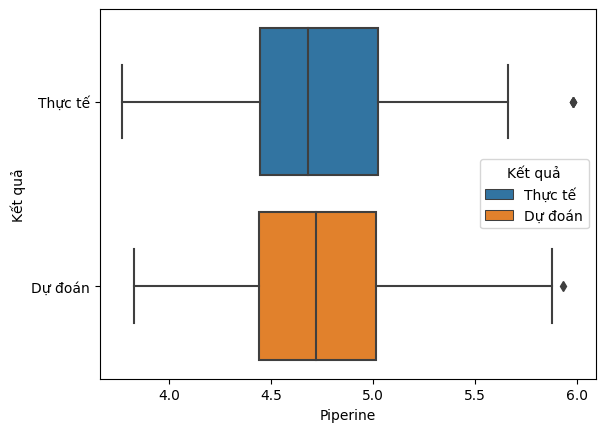

In [ ]:
# Create dictionaries to store the data with corresponding machine information
actual_data = {'Piperine': y, 'Kết quả': ['Thực tế'] * len(y)}
pred_data = {'Piperine': np.squeeze(mean_predictions), 'Kết quả': ['Dự đoán'] * len(mean_predictions)}

# Convert the dictionaries to DataFrames
actual_df = pd.DataFrame(actual_data)
pred_df = pd.DataFrame(pred_data)

# Concatenate the DataFrames along the rows
result_df = pd.concat([actual_df, pred_df], ignore_index=True)


#sns.displot(result_df, x="Piperine", hue="Kết quả", kind="kde",fill=True)

sns.boxplot(result_df, x="Piperine", y = "Kết quả", hue="Kết quả", dodge=False)

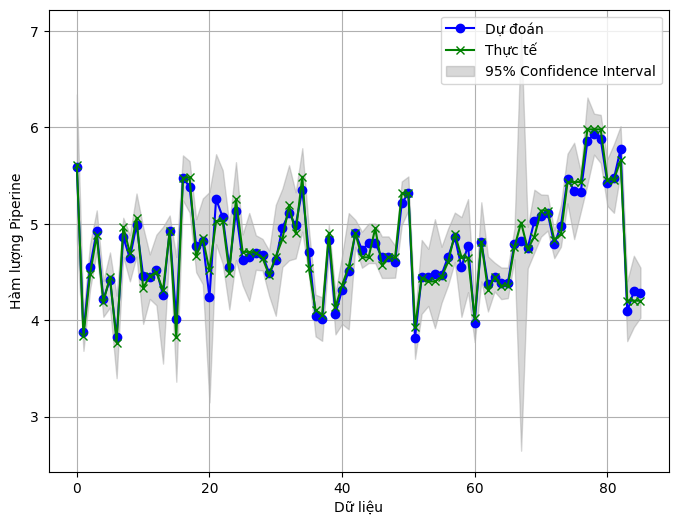

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.plot(np.squeeze(mean_predictions), label='Dự đoán', marker='o', color='blue')
plt.plot(y, label='Thực tế', marker='x', color='green')
plt.fill_between(np.arange(len(np.squeeze(mean_predictions))),
                 np.squeeze(mean_predictions) - np.squeeze(confidence_interval),
                 np.squeeze(mean_predictions) + np.squeeze(confidence_interval),
                 color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Dữ liệu')
plt.ylabel('Hàm lượng Piperine')
#plt.title('Predicted Values vs Actual Values with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import pearsonr, kendalltau, spearmanr

# Assuming 'pdf' is a pandas DataFrame containing 'truth' and 'predicted' columns

# Define the scoring functions
def MAE(truth, predicted):
    return np.mean(np.abs(truth - predicted))

def MAPE(truth, predicted):
    return np.mean(np.abs((truth - predicted) / truth)) * 100.0

def MEDAE(truth, predicted):
    return np.median(np.abs(truth - predicted))

def MEDSE(truth, predicted):
    return np.median((truth - predicted) ** 2)

def MSE(truth, predicted):
    return np.mean((truth - predicted) ** 2)

def MSLE(truth, predicted):
    return np.mean((np.log1p(truth) - np.log1p(predicted)) ** 2)

def RAE(truth, predicted):
    return np.sum(np.abs(truth - predicted)) / np.sum(np.abs(truth - np.mean(truth)))

def RMSE(truth, predicted):
    return np.sqrt(np.mean((truth - predicted) ** 2))

def RMSLE(truth, predicted):
    return np.sqrt(np.mean((np.log1p(truth) - np.log1p(predicted)) ** 2))

def RRSE(truth, predicted):
    return np.sqrt(np.sum((truth - predicted) ** 2)) / np.sqrt(np.sum((truth - np.mean(truth)) ** 2))

def RSQ(truth, predicted):
    total_variance = np.sum((truth - np.mean(truth)) ** 2)
    residual_variance = np.sum((truth - predicted) ** 2)
    return 1 - (residual_variance / total_variance)

def SAE(truth, predicted):
    return np.sum(np.abs(truth - predicted))

def SSE(truth, predicted):
    return np.sum((truth - predicted) ** 2)

def PearsonR(truth, predicted):
    return pearsonr(truth, predicted)[0]

def KendallTau(truth, predicted):
    return kendalltau(truth, predicted)[0]

def SpearmanRho(truth, predicted):
    return spearmanr(truth, predicted)[0]

def R2(truth, predicted):
    total_variance = np.sum((truth - np.mean(truth)) ** 2)
    residual_variance = np.sum((truth - predicted) ** 2)
    return 1 - (residual_variance / total_variance)
# List of scoring methods
methods = [
    MAE, MAPE, MEDAE, MEDSE, MSE, MSLE, RAE, RMSE, RMSLE, RRSE, RSQ, SAE, SSE,
    PearsonR, KendallTau, SpearmanRho, R2
]

# Assuming 'pdf' is a pandas DataFrame containing 'truth' and 'predicted' columns
truth = y
predicted = np.squeeze(mean_predictions)

# Calculate scores using the defined scoring functions
scores = [method(truth, predicted) for method in methods]

# Store the scores in a DataFrame with method names as column names
scores_df = pd.DataFrame({'method': [method.__name__ for method in methods], 'score': scores})


print(scores_df)


         method     score
0           MAE  0.067805
1          MAPE  1.433200
2         MEDAE  0.060777
3         MEDSE  0.003706
4           MSE  0.007110
5          MSLE  0.000216
6           RAE  0.174440
7          RMSE  0.084323
8         RMSLE  0.014689
9          RRSE  0.171650
10          RSQ  0.970536
11          SAE  5.831224
12          SSE  0.611491
13     PearsonR  0.985426
14   KendallTau  0.889681
15  SpearmanRho  0.980083
16           R2  0.970536


In [ ]:
# Convert to 1-dimensional arrays
mean_predictions = np.squeeze(mean_predictions)
confidence_interval = np.squeeze(confidence_interval)

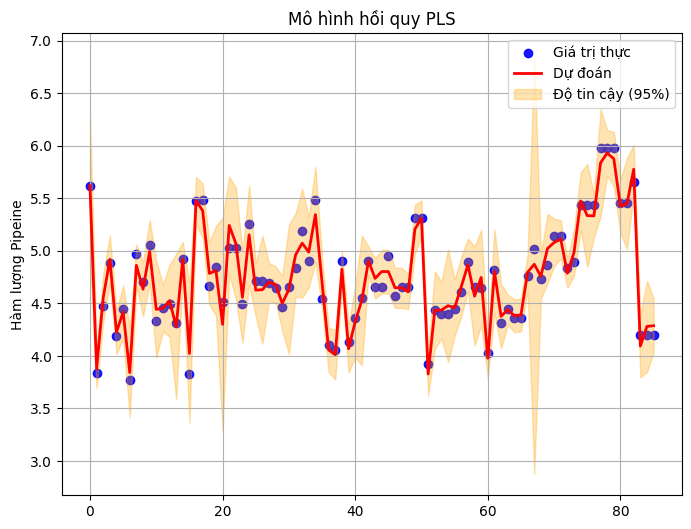

In [ ]:
# Plot confidence interval as a shaded region
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y)), y, label="Giá trị thực", color='b', alpha=0.9)
plt.plot(mean_predictions, label="Dự đoán", color='r', linewidth=2)
plt.fill_between(range(len(mean_predictions)),
                 np.squeeze(mean_predictions) - np.squeeze(confidence_interval),
                 np.squeeze(mean_predictions) + np.squeeze(confidence_interval),
                 color='orange', alpha=0.3, label="Độ tin cậy (95%)")
plt.ylabel("Hàm lượng Pipeine")
plt.title(f"Mô hình hồi quy PLS")
plt.legend()
plt.grid(True)
plt.show()

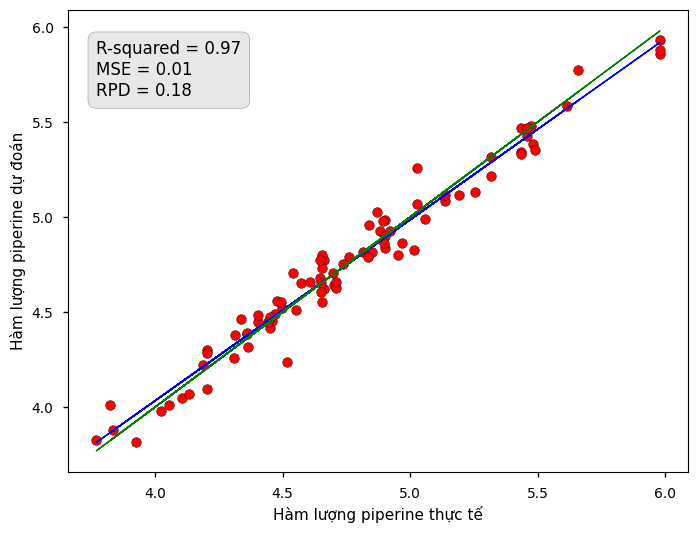

In [ ]:
z = np.polyfit(y, mean_predictions, 1)

r2 = r2_score(y, mean_predictions)
mse = mean_squared_error(y, mean_predictions)
rpd = np.sqrt(mse) / np.std(y)


with plt.style.context(('seaborn-notebook')):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(y, mean_predictions, c='red', edgecolors='k')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1)

    plt.text(min(y), max(mean_predictions), f'R-squared = {r2:.2f}\nMSE = {mse:.2f}\nRPD = {rpd:.2f}', fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.5))
    plt.xlabel('Hàm lượng piperine thực tế')
    plt.ylabel('Hàm lượng piperine dự đoán')
    plt.title('')

    plt.show()

In [ ]:
np.where(abs(y- np.squeeze(mean_predictions)) > 0.1)

(array([ 7, 10, 15, 17, 18, 20, 21, 24, 31, 32, 34, 35, 44, 45, 49, 51, 58,
        59, 67, 69, 75, 76, 77, 82, 83]),)

In [ ]:
y1 = np.delete(np.array(y), [ 7, 10, 15, 17, 18, 20, 21, 24, 31, 32, 34, 35, 44, 45, 49, 51, 58,
        59, 67, 69, 75, 76, 77, 82, 83], axis=0)

mean_predictions_2 = np.delete(np.squeeze(mean_predictions), [ 7, 10, 15, 17, 18, 20, 21, 24, 31, 32, 34, 35, 44, 45, 49, 51, 58,
        59, 67, 69, 75, 76, 77, 82, 83], axis=0)

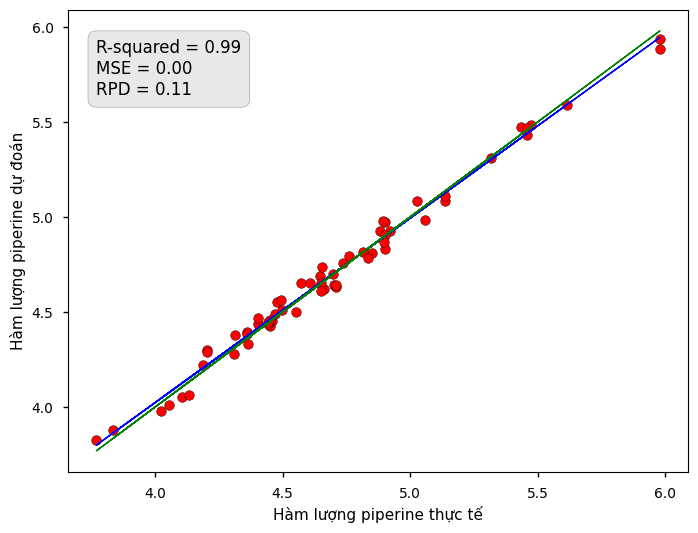

In [ ]:
z = np.polyfit(y1, mean_predictions_2, 1)

r2 = r2_score(y1, mean_predictions_2)
mse = mean_squared_error(y1, mean_predictions_2)
rpd = np.sqrt(mse) / np.std(y1)


with plt.style.context(('seaborn-notebook')):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(y1, mean_predictions_2, c='red', edgecolors='k')
    ax.plot(y1, z[1]+z[0]*y1, c='blue', linewidth=1)
    ax.plot(y1, y1, color='green', linewidth=1)

    plt.text(min(y1), max(mean_predictions_2), f'R-squared = {r2:.2f}\nMSE = {mse:.2f}\nRPD = {rpd:.2f}', fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.5))
    plt.xlabel('Hàm lượng piperine thực tế')
    plt.ylabel('Hàm lượng piperine dự đoán')
    plt.title('')

    plt.show()

In [ ]:
len(y1)

61

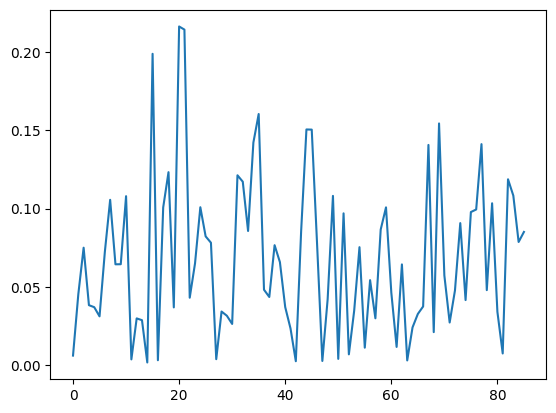

In [ ]:
plt.plot(abs(ground_truth_values - predicted_values))

In [ ]:
# Giả định ta có các giá trị thực tế và dự đoán cho một số mẫu kiểm tra
ground_truth_values = y
predicted_values = np.squeeze(mean_predictions)

# Độ chính xác và độ lặp lại: Tính độ chính xác và độ lặp lại bằng cách so sánh giá trị thực tế với giá trị dự đoán
def accuracy_and_repeatability(ground_truth, predicted):
    correct_predictions = [1 if abs(gt - pred) < 0.1 else 0 for (gt, pred) in zip(ground_truth, predicted)]
    accuracy = sum(correct_predictions) / len(correct_predictions)
    repeatability = sum(correct_predictions) / len(correct_predictions)  # Ở đây ta giả định cùng một mẫu được đo lặp lại nhiều lần
    return accuracy, repeatability

# Giới hạn phát hiện và giới hạn định lượng: Giả định ta có các giá trị ngưỡng cho giới hạn phát hiện và giới hạn định lượng
detection_limit = 1.5
quantification_limit = 2.0

# Độ nhạy và độ phân giải: Tính độ nhạy và độ phân giải bằng cách sử dụng các giá trị từ dữ liệu thực tế
def sensitivity_and_resolution(ground_truth):
    sensitivity = max(ground_truth) - min(ground_truth)
    resolution = sensitivity / 10  # Ở đây, ta giả định có 10 khoảng chia trong khoảng giá trị của piperine
    return sensitivity, resolution



# Tính tương tác chéo bằng cách kiểm tra sự tương tác giữa giá trị piperine và tạp chất
def cross_interference(data_with_interferences):
    cross_interference_values = [1 if abs(piperine - interference) < 0.2 else 0 for (_, piperine, interference) in data_with_interferences]
    cross_interference = sum(cross_interference_values) / len(cross_interference_values)
    return cross_interference

# Tính toán các yếu tố đánh giá
accuracy, repeatability = accuracy_and_repeatability(ground_truth_values, predicted_values)
sensitivity, resolution = sensitivity_and_resolution(ground_truth_values)


# In kết quả đánh giá
print(f"Độ chính xác: {accuracy}")
print(f"Độ lặp lại: {repeatability}")
print(f"Giới hạn phát hiện: {detection_limit}")
print(f"Giới hạn định lượng: {quantification_limit}")
print(f"Độ nhạy: {sensitivity}")
print(f"Độ phân giải: {resolution}")

Độ chính xác: 0.7441860465116279
Độ lặp lại: 0.7441860465116279
Giới hạn phát hiện: 1.5
Giới hạn định lượng: 2.0
Độ nhạy: 2.2106000000000017
Độ phân giải: 0.22106000000000017


In [ ]:
y

array([4.00139573, 1.10694503, 3.46216225, 1.4842236 , 1.69841823,
       2.47568241, 1.62716455, 2.76261794, 1.86474547, 2.47329424,
       4.56300374, 2.34260464, 1.99431644, 2.03304496, 1.98395488,
       3.7489102 , 3.76207461, 3.16266197, 2.71430883, 2.83184518,
       2.02250555, 2.09327085, 1.54004516, 4.29866632, 4.53331744,
       3.62616096, 1.4076667 , 2.68205489, 2.96209713, 2.07895775,
       2.76278008, 2.89289446, 3.06717833, 2.73295629, 1.86701353,
       2.79044783, 1.46000366, 4.14639219, 3.39259943, 3.46170447,
       1.5208052 , 0.72316476, 3.60497625, 1.64806902, 2.94866313,
       3.3996366 , 3.35904515, 2.37113353, 5.3503708 , 3.63192646,
       2.33262086, 4.1320716 , 4.09987977, 3.91827173, 4.5210052 ,
       3.71963062, 2.77504342, 1.73108892, 0.4538984 , 3.52934495,
       2.00440472, 3.56809546, 1.07460067, 2.59953305, 3.56607188,
       3.5402306 , 2.89410783, 3.05007294, 2.43722224, 3.08034587,
       3.89438582, 1.55373605, 2.87996602, 3.9886645 , 0.49991

In [ ]:
pls = PLSRegression(n_components=ncomp)
pls.fit(opt_Xc, y1)

y_cv = cross_val_predict(pls, opt_Xc, y1, cv=5)
residual = abs(np.array(y1).flatten()- y_cv.flatten())

b = np.where(residual>0.5)


100% completed
Optimised number of PLS components:  23
Wavelengths to be discarded  188
Optimised MSEP  0.1783169700348187

R2 calib: 0.738
R2 CV: 0.434
MSE calib: 0.082
MSE CV: 0.178


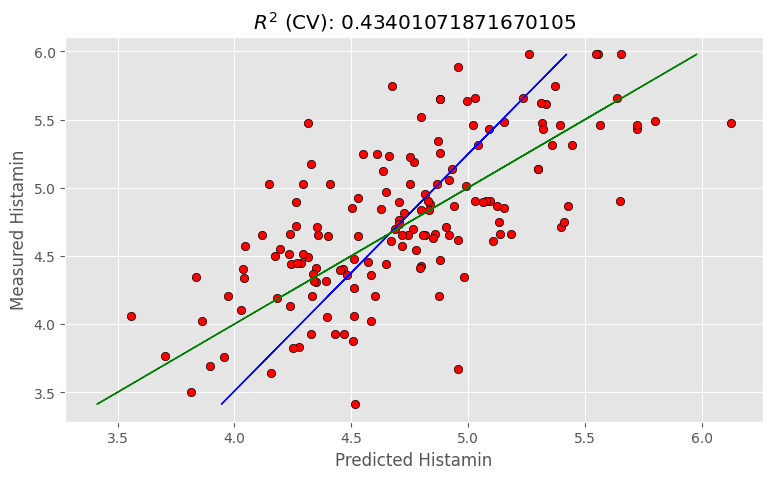

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X_SNV,y1, 30)
simple_pls_cv(opt_Xc, y1, ncomp)

pls = PLSRegression(n_components=ncomp)
pls.fit(opt_Xc, y1)

y_cv = cross_val_predict(pls, opt_Xc, y1, cv=5)
residual = abs(np.array(y1).flatten()- y_cv.flatten())

c = np.where(residual>0.5)

100% completed
Optimised number of PLS components:  23
Wavelengths to be discarded  188
Optimised MSEP  0.17182191074150469

R2 calib: 0.741
R2 CV: 0.455
MSE calib: 0.082
MSE CV: 0.172


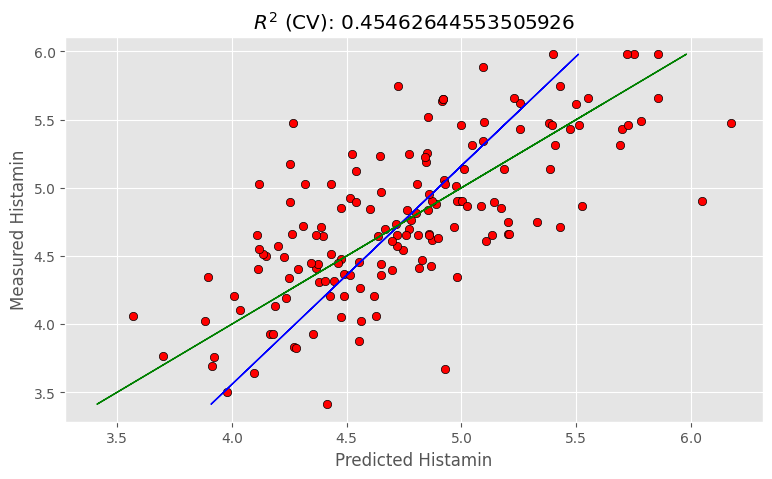

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X_MSC,y1, 30)
simple_pls_cv(opt_Xc, y1, ncomp)

pls = PLSRegression(n_components=ncomp)
pls.fit(opt_Xc, y1)

y_cv = cross_val_predict(pls, opt_Xc, y1, cv=5)
residual = abs(np.array(y1).flatten()- y_cv.flatten())

d = np.where(residual>0.5)

100% completed
Optimised number of PLS components:  12
Wavelengths to be discarded  143
Optimised MSEP  0.19491882510938566

R2 calib: 0.580
R2 CV: 0.381
MSE calib: 0.132
MSE CV: 0.195


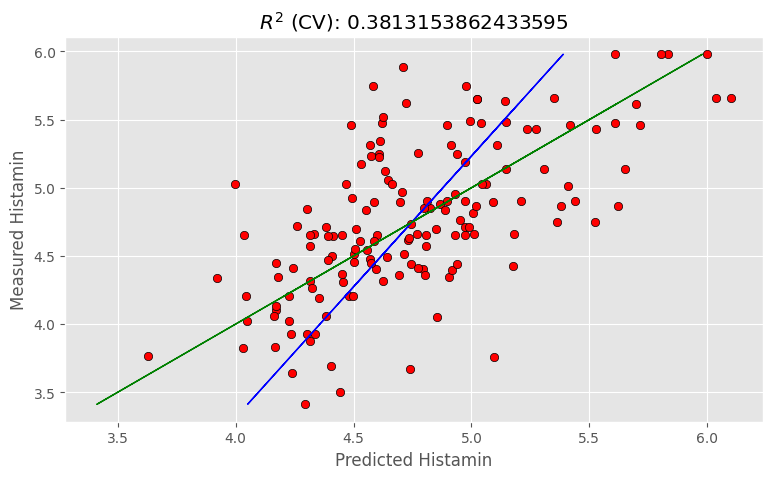

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X_SG1,y1, 30)
simple_pls_cv(opt_Xc, y1, ncomp)

pls = PLSRegression(n_components=ncomp)
pls.fit(opt_Xc, y1)

y_cv = cross_val_predict(pls, opt_Xc, y1, cv=5)
residual = abs(np.array(y1).flatten()- y_cv.flatten())

e = np.where(residual>0.5)

100% completed
Optimised number of PLS components:  16
Wavelengths to be discarded  171
Optimised MSEP  0.17756002562247472

R2 calib: 0.694
R2 CV: 0.436
MSE calib: 0.096
MSE CV: 0.178


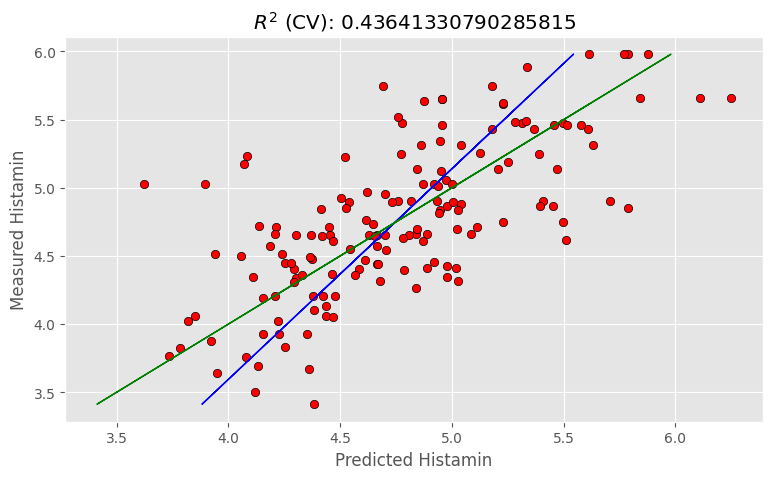

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X_SG2,y1, 30)
simple_pls_cv(opt_Xc, y1, ncomp)

pls = PLSRegression(n_components=ncomp)
pls.fit(opt_Xc, y1)

y_cv = cross_val_predict(pls, opt_Xc, y1, cv=5)
residual = abs(np.array(y1).flatten()- y_cv.flatten())

f = np.where(residual>0.5)

In [ ]:
merged_array = np.concatenate(( np.array(b).flatten(),
                               np.array(c).flatten(), np.array(d).flatten(),
                               np.array(e).flatten(), np.array(f).flatten()))


In [ ]:
merged_array

array([  5,  10,  21,  24,  25,  32,  33,  35,  54,  56,  60,  62,  64,
        75,  82,  94,  96,  98, 102, 105, 107, 109, 125, 127, 136, 141,
       145, 147,   5,  10,  21,  22,  25,  27,  28,  34,  35,  36,  37,
        40,  41,  48,  54,  56,  60,  64,  70,  78,  86,  90,  94,  95,
        96, 104, 105, 109, 114, 121, 122, 125, 137, 141, 148, 152,   5,
        10,  11,  21,  22,  25,  27,  28,  29,  34,  36,  37,  40,  41,
        48,  54,  56,  60,  62,  64,  78,  90,  94, 104, 105, 109, 121,
       122, 125, 137, 141,   5,   6,  10,  21,  24,  25,  27,  32,  34,
        37,  38,  40,  44,  51,  54,  56,  60,  64,  75,  78,  79,  82,
        91,  94, 102, 107, 114, 121, 122, 125, 126, 127, 129, 141, 142,
       145, 146,   5,  10,  19,  21,  24,  25,  33,  36,  37,  38,  40,
        50,  54,  56,  59,  60,  64,  67,  68,  72,  78,  79,  81,  94,
       121, 122, 125, 126, 127, 141, 146, 148])

In [ ]:
pd.Data

100% completed
Optimised number of PLS components:  26
Wavelengths to be discarded  163
Optimised MSEP  0.0405049132515204

R2 calib: 0.965
R2 CV: 0.832
MSE calib: 0.009
MSE CV: 0.041


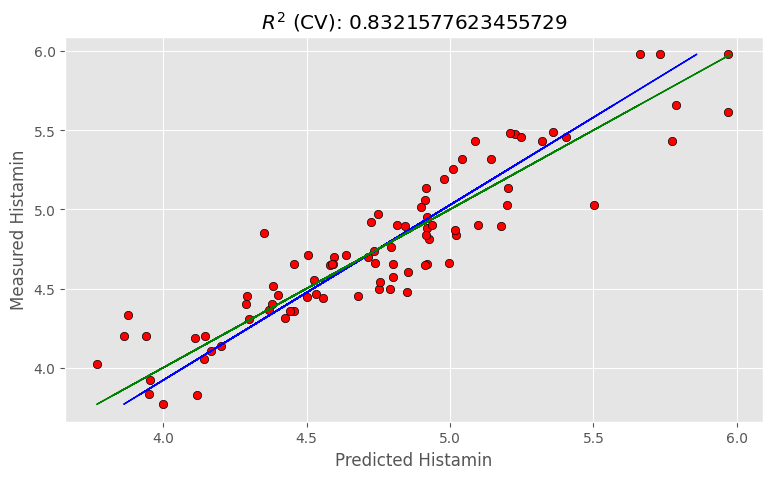

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X_fix,y2, 30)
simple_pls_cv(opt_Xc, y2, ncomp)

100% completed
Optimised number of PLS components:  24
Wavelengths to be discarded  189
Optimised MSEP  0.1472313646095016

R2 calib: 0.774
R2 CV: 0.477
MSE calib: 0.064
MSE CV: 0.147


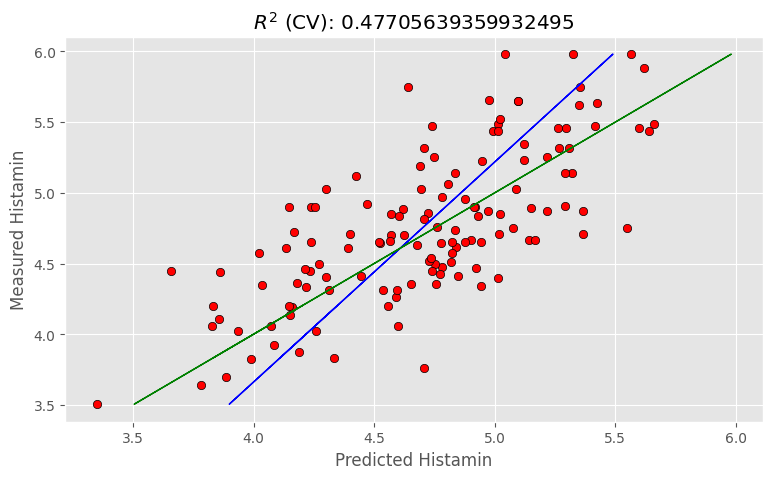

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(snv(X_fix),y2, 30)
simple_pls_cv(opt_Xc, y2, ncomp)

In [ ]:
X1_fix2 = np.delete(X1_fix, [18, 27, 38], axis=0)


y3 = y2.drop([18, 27, 38], axis=0)
y3 = y3.reset_index(drop=True)

In [ ]:
X1_fix = np.delete(X1[1], [  5,  10,  21,  22,  25,  28,  34,  35,  36,  37,  40,  41,  48,
         54,  60,  64,  78,  94, 109, 121, 122, 137, 141, 148, 152], axis=0)


y2 = y1.drop([  5,  10,  21,  22,  25,  28,  34,  35,  36,  37,  40,  41,  48,
         54,  60,  64,  78,  94, 109, 121, 122, 137, 141, 148, 152], axis=0)
y2 = y2.reset_index(drop=True)

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1[1],y1 , 30)



100% completed
Optimised number of PLS components:  23
Wavelengths to be discarded  188
Optimised MSEP  0.1783169700348187



In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1_fix,y2 , 30)


100% completed
Optimised number of PLS components:  22
Wavelengths to be discarded  177
Optimised MSEP  0.07009077050003988



In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1_fix2,y3 , 30)


100% completed
Optimised number of PLS components:  21
Wavelengths to be discarded  196
Optimised MSEP  0.07207411599845905



In [ ]:
pls = PLSRegression(n_components=ncomp)
pls.fit(opt_Xc, y3)

y_cv = cross_val_predict(pls, opt_Xc, y3, cv=5)

In [ ]:
type(y_cv)

numpy.ndarray

In [ ]:
fig = px.scatter(y=np.array(y2).flatten(), x=y_cv.flatten(), trendline="ols")
fig.show()

In [ ]:
b = abs(np.array(y3).flatten()- y_cv.flatten())

np.where(b>0.6)

(array([80]),)

R2 calib: 0.854
R2 CV: 0.725
MSE calib: 0.038
MSE CV: 0.072


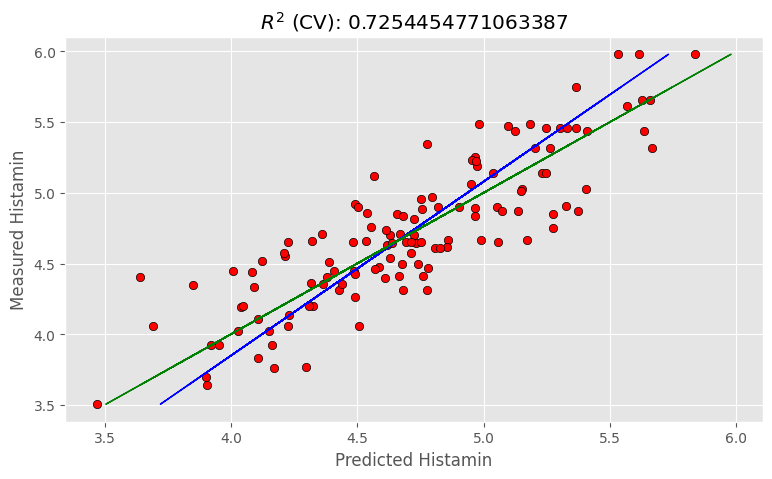

In [ ]:
simple_pls_cv(opt_Xc, y3, ncomp)

R2 calib: 0.738
R2 CV: 0.434
MSE calib: 0.082
MSE CV: 0.178


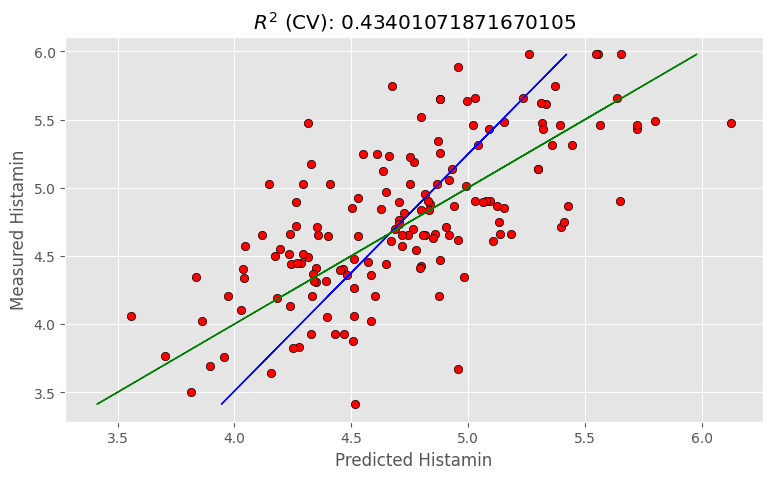

In [ ]:
simple_pls_cv(opt_Xc, y1, ncomp)

RAW
100% completed
Optimised number of PLS components:  26
Wavelengths to be discarded  163
Optimised MSEP  0.0405049132515204

R2 calib: 0.965
R2 CV: 0.832
MSE calib: 0.009
MSE CV: 0.041


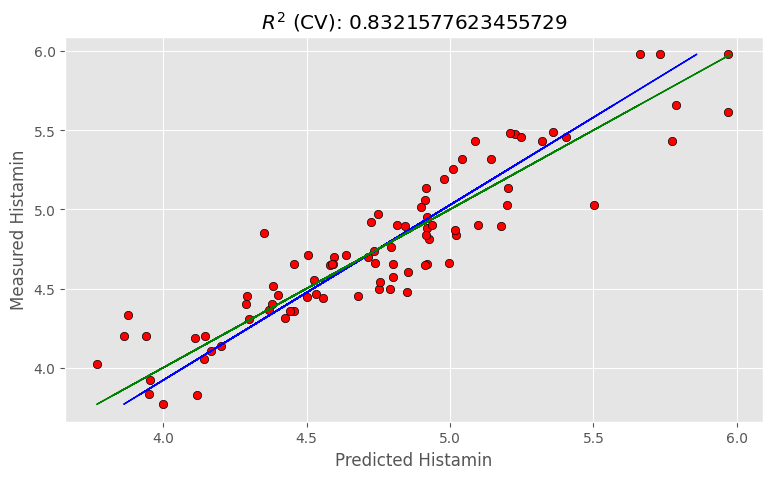

SNV
100% completed
Optimised number of PLS components:  29
Wavelengths to be discarded  172
Optimised MSEP  0.03965607799164264

R2 calib: 0.980
R2 CV: 0.836
MSE calib: 0.005
MSE CV: 0.040


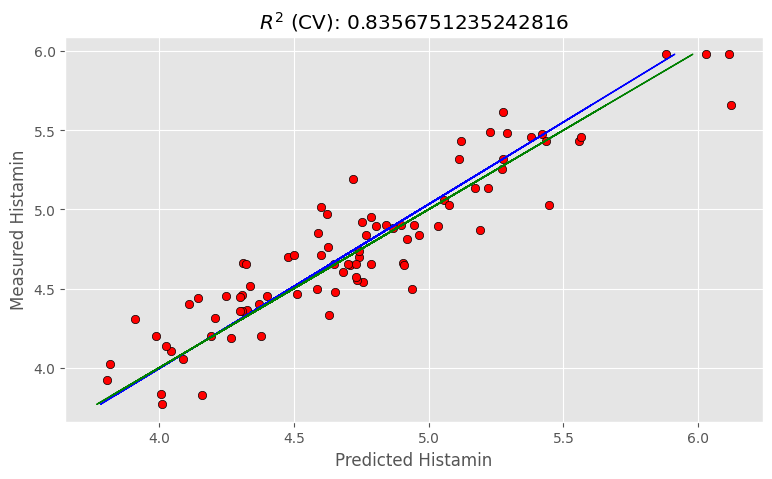

MSC
100% completed
Optimised number of PLS components:  29
Wavelengths to be discarded  164
Optimised MSEP  0.036084157456006995

R2 calib: 0.980
R2 CV: 0.850
MSE calib: 0.005
MSE CV: 0.036


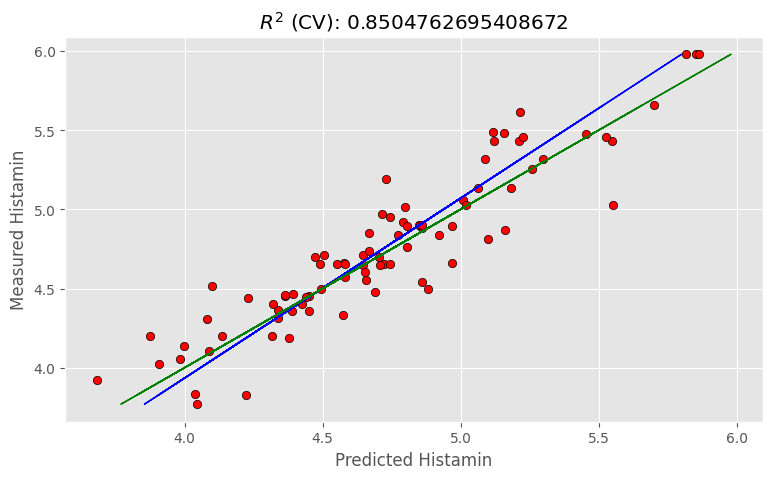

SG1
100% completed
Optimised number of PLS components:  15
Wavelengths to be discarded  149
Optimised MSEP  0.06351195809281986

R2 calib: 0.875
R2 CV: 0.737
MSE calib: 0.030
MSE CV: 0.064


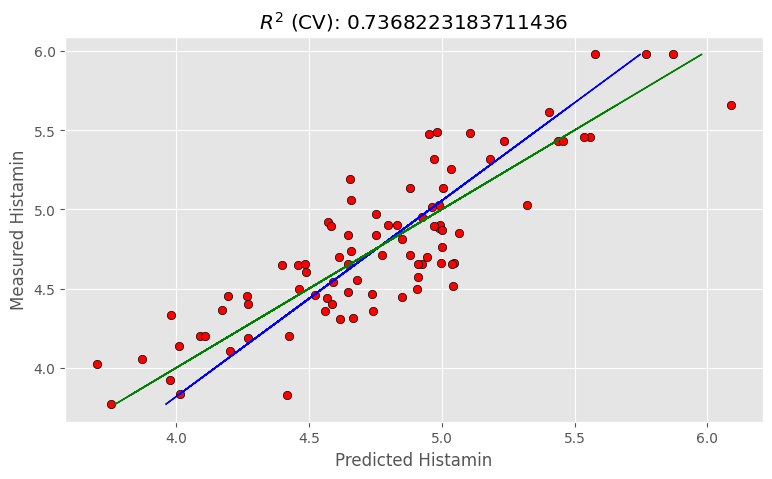

SG2
100% completed
Optimised number of PLS components:  16
Wavelengths to be discarded  192
Optimised MSEP  0.0666900180968383

R2 calib: 0.895
R2 CV: 0.724
MSE calib: 0.025
MSE CV: 0.067


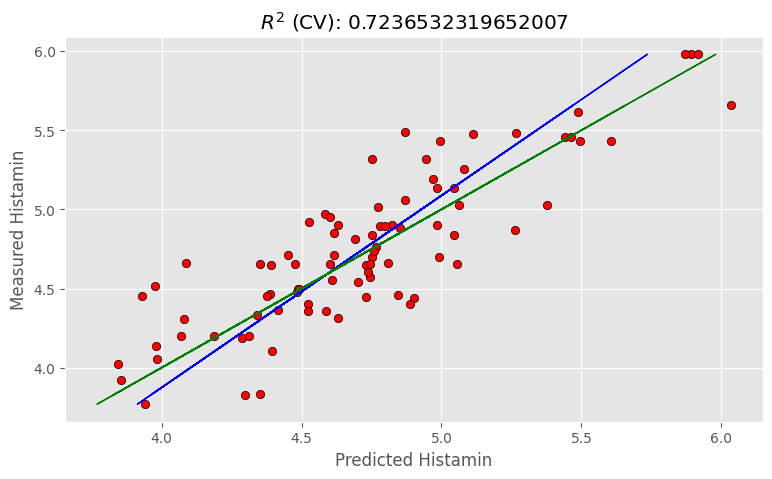

In [ ]:
y1 = y['Peperine']
for i in range(len(name_preprocess)):
    print(name_preprocess[i])
    opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1[i],y1 , 30)
    simple_pls_cv(opt_Xc, y1, ncomp)

RAW
100% completed
Optimised number of PLS components:  26
Wavelengths to be discarded  175
Optimised MSEP  0.1250746769530612

R2 calib: 0.888
R2 CV: 0.337
MSE calib: 0.021
MSE CV: 0.125


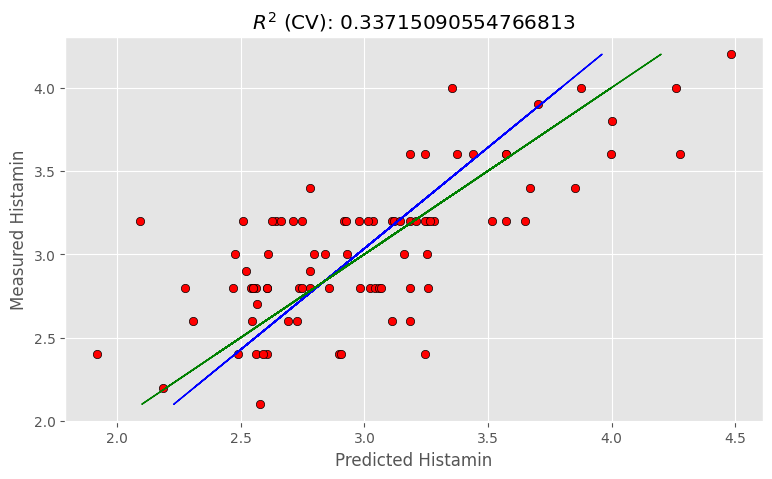

SNV
100% completed
Optimised number of PLS components:  29
Wavelengths to be discarded  171
Optimised MSEP  0.1008881831911559

R2 calib: 0.932
R2 CV: 0.465
MSE calib: 0.013
MSE CV: 0.101


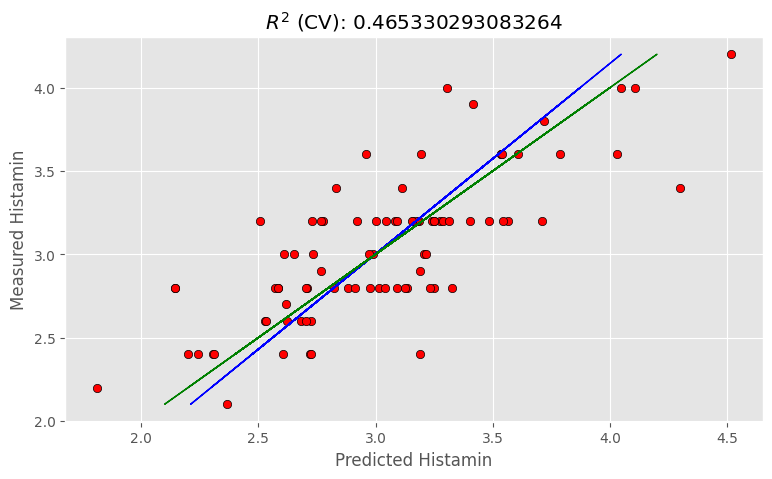

MSC
100% completed
Optimised number of PLS components:  22
Wavelengths to be discarded  190
Optimised MSEP  0.09967237162319675

R2 calib: 0.858
R2 CV: 0.472
MSE calib: 0.027
MSE CV: 0.100


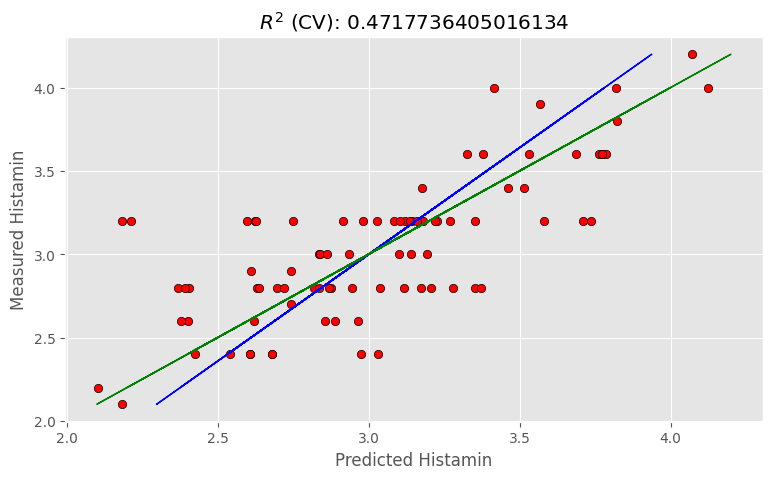

SG1
100% completed
Optimised number of PLS components:  14
Wavelengths to be discarded  148
Optimised MSEP  0.1355190101165863

R2 calib: 0.567
R2 CV: 0.282
MSE calib: 0.082
MSE CV: 0.136


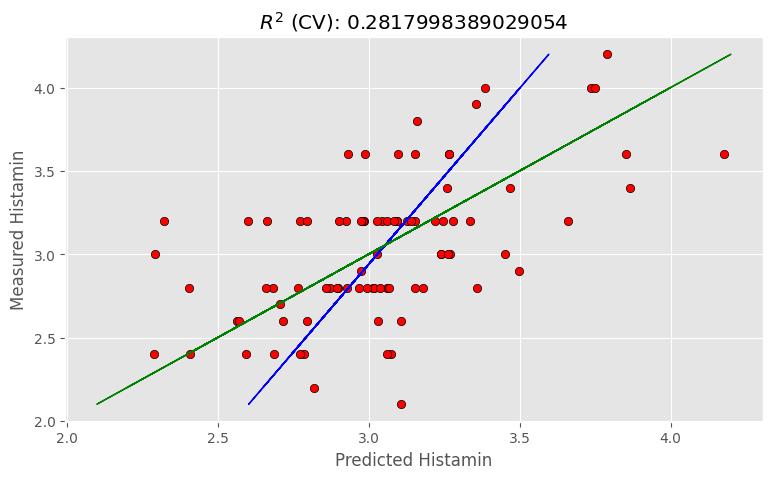

SG2
100% completed
Optimised number of PLS components:  15
Wavelengths to be discarded  180
Optimised MSEP  0.10732799344459396

R2 calib: 0.708
R2 CV: 0.431
MSE calib: 0.055
MSE CV: 0.107


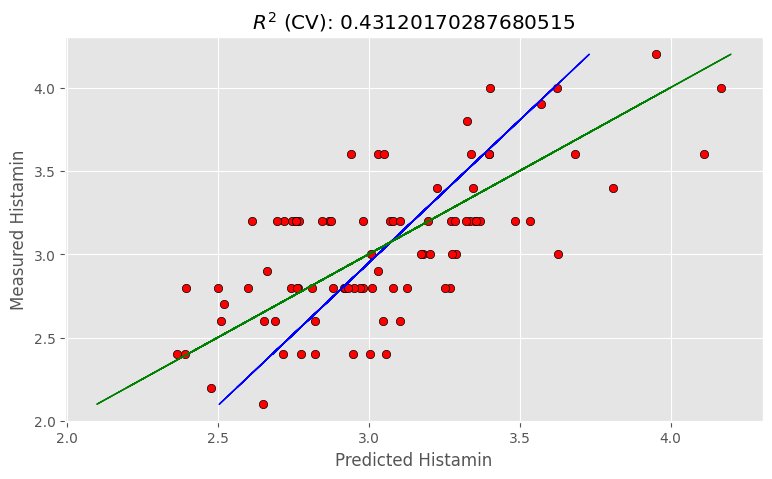

In [ ]:
y1 = y['TinhDau']
for i in range(len(name_preprocess)):
    print(name_preprocess[i])
    opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1[i],y1 , 30)
    simple_pls_cv(opt_Xc, y1, ncomp)

RAW
100% completed
Optimised number of PLS components:  28
Wavelengths to be discarded  182
Optimised MSEP  0.9346304470790174

R2 calib: 0.863
R2 CV: 0.610
MSE calib: 0.373
MSE CV: 1.058


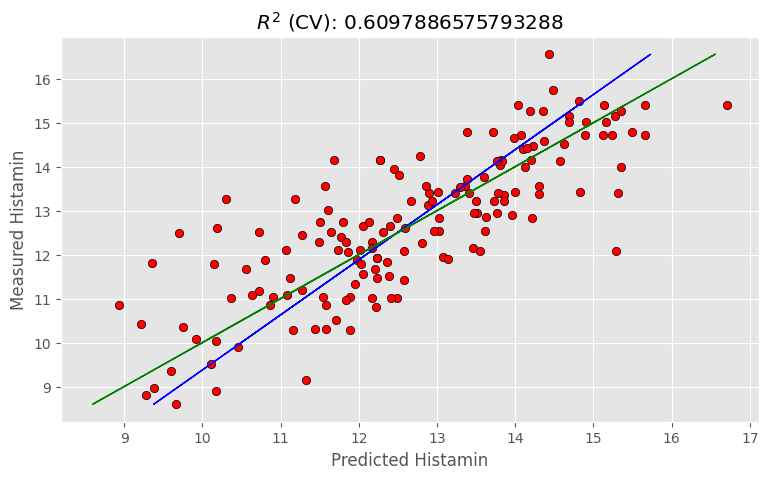

SNV
100% completed
Optimised number of PLS components:  28
Wavelengths to be discarded  183
Optimised MSEP  0.8644810143159172

R2 calib: 0.865
R2 CV: 0.667
MSE calib: 0.365
MSE CV: 0.904


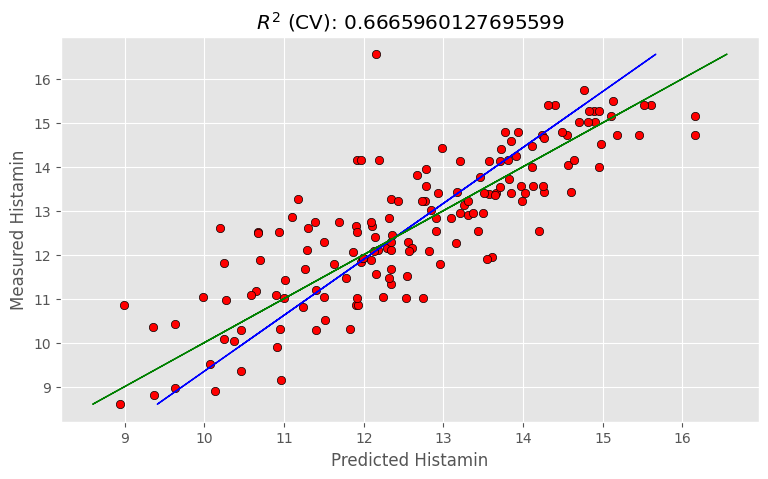

MSC
100% completed
Optimised number of PLS components:  29
Wavelengths to be discarded  178
Optimised MSEP  0.8103066359936242

R2 calib: 0.886
R2 CV: 0.724
MSE calib: 0.308
MSE CV: 0.749


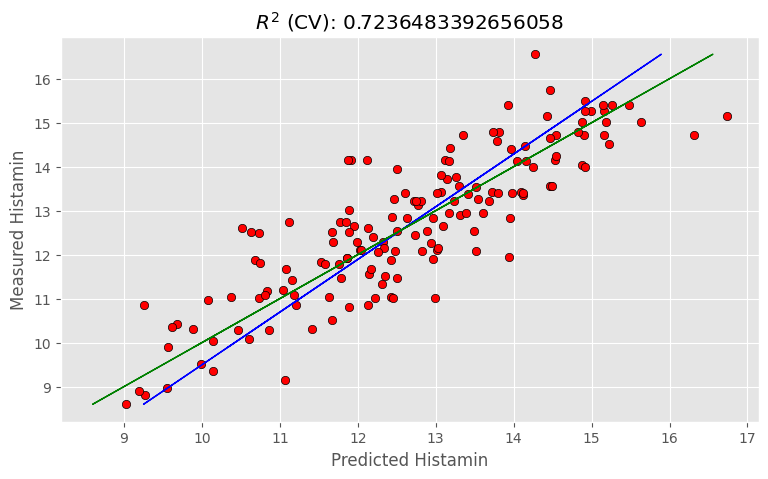

SG1
100% completed
Optimised number of PLS components:  18
Wavelengths to be discarded  198
Optimised MSEP  1.1473402740807952

R2 calib: 0.741
R2 CV: 0.537
MSE calib: 0.704
MSE CV: 1.256


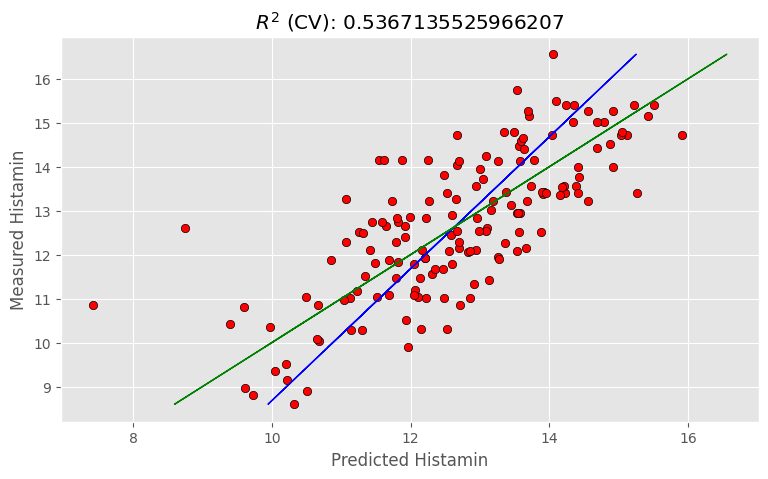

SG2
100% completed
Optimised number of PLS components:  18
Wavelengths to be discarded  183
Optimised MSEP  0.8376221306242151

R2 calib: 0.833
R2 CV: 0.690
MSE calib: 0.452
MSE CV: 0.841


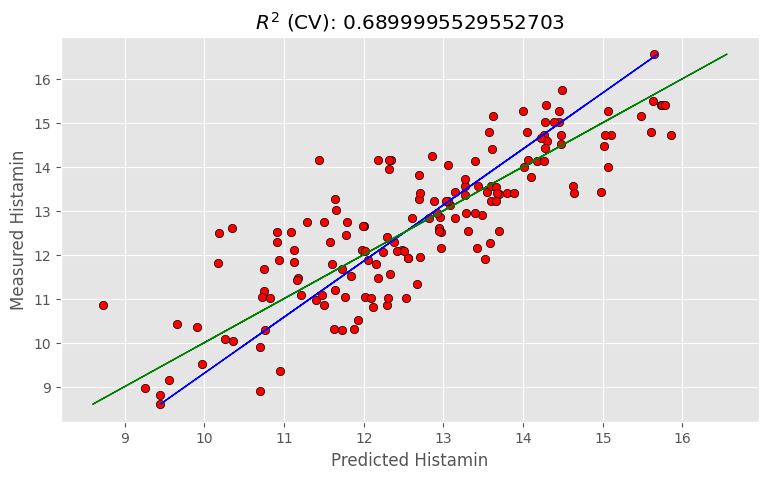

In [ ]:
y1 = y['DoAm']
for i in range(len(name_preprocess)):
    print(name_preprocess[i])
    opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1[i],y1 , 30)
    simple_pls_cv(opt_Xc, y1, ncomp)

RAW
100% completed
Optimised number of PLS components:  4
Wavelengths to be discarded  219
Optimised MSEP  0.14636614527645678

R2 calib: 0.220
R2 CV: 0.125
MSE calib: 0.130
MSE CV: 0.146


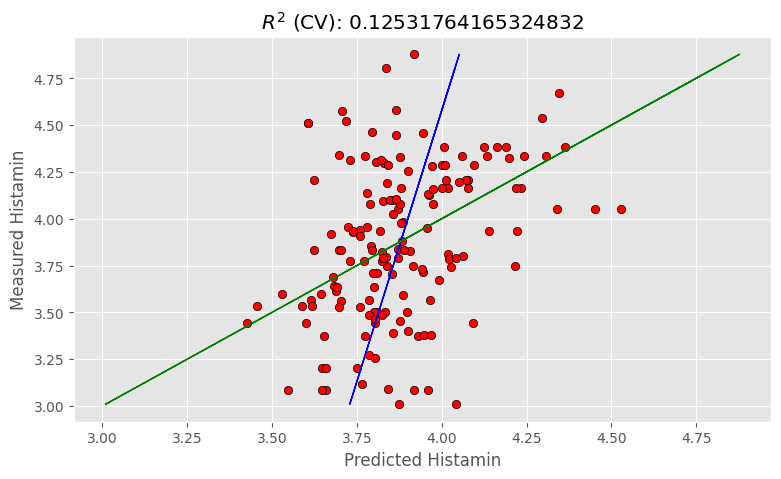

SNV
100% completed
Optimised number of PLS components:  4
Wavelengths to be discarded  211
Optimised MSEP  0.14074179230309644

R2 calib: 0.246
R2 CV: 0.158
MSE calib: 0.126
MSE CV: 0.141


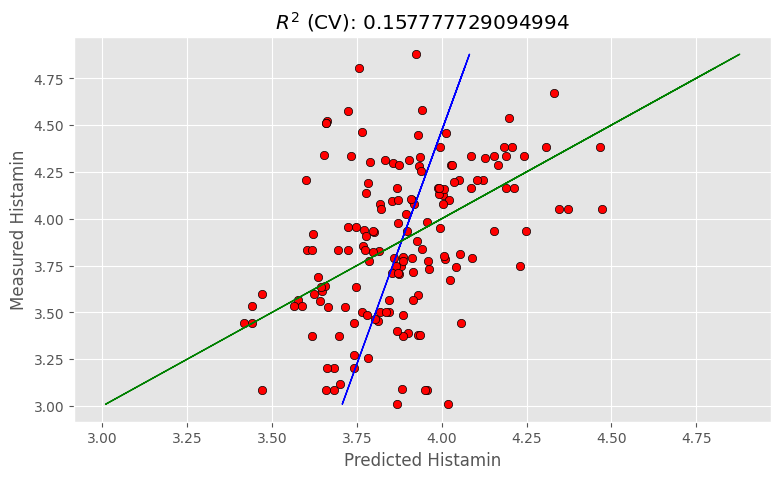

MSC
100% completed
Optimised number of PLS components:  19
Wavelengths to be discarded  202
Optimised MSEP  0.13726252791084073

R2 calib: 0.543
R2 CV: 0.341
MSE calib: 0.076
MSE CV: 0.110


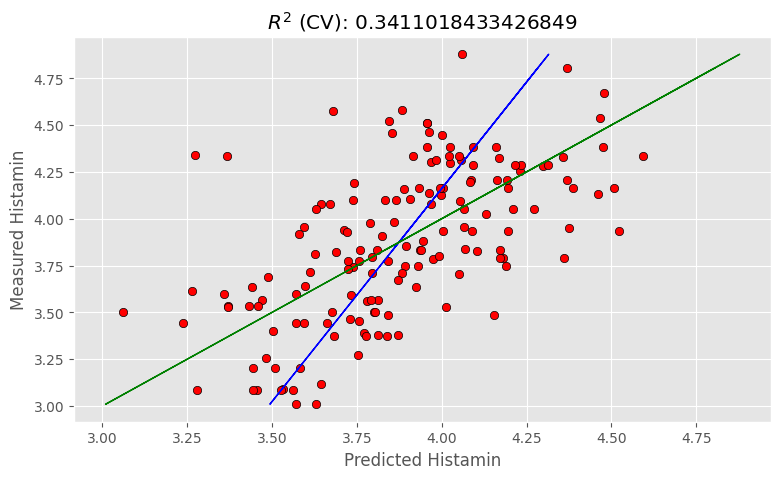

SG1
100% completed
Optimised number of PLS components:  3
Wavelengths to be discarded  184
Optimised MSEP  0.14621844744028403

R2 calib: 0.224
R2 CV: 0.116
MSE calib: 0.130
MSE CV: 0.148


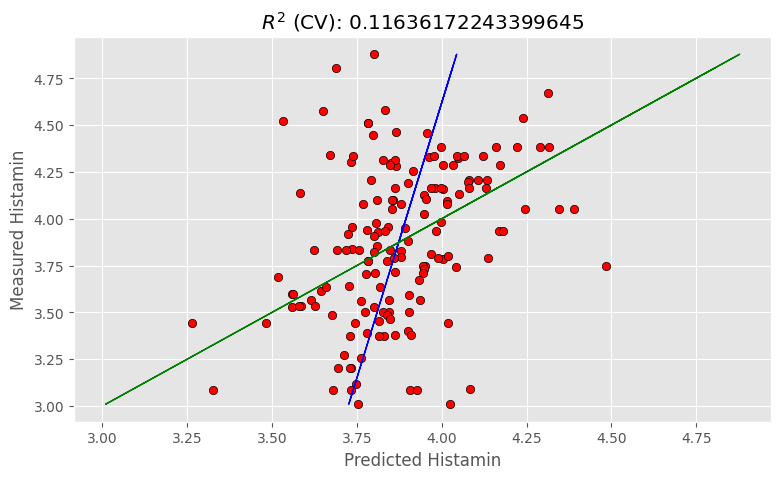

SG2
100% completed
Optimised number of PLS components:  5
Wavelengths to be discarded  214
Optimised MSEP  0.14858740566665668

R2 calib: 0.276
R2 CV: 0.152
MSE calib: 0.121
MSE CV: 0.142


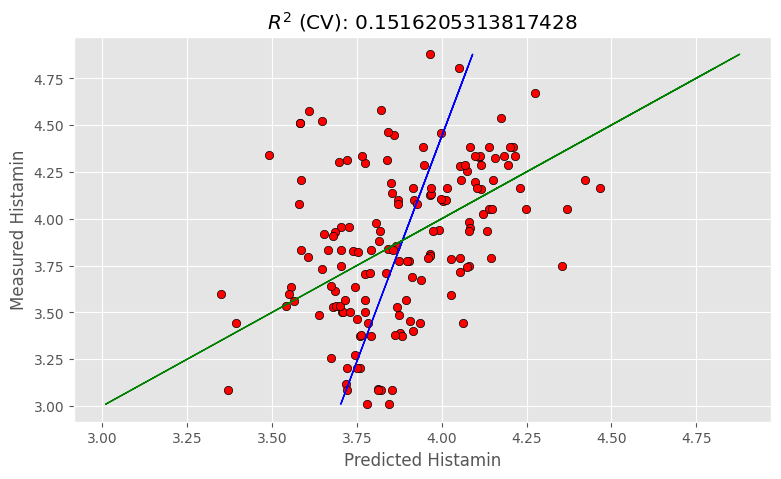

In [ ]:
y1 = y['TroTong']
for i in range(len(name_preprocess)):
    print(name_preprocess[i])
    opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1[i],y1 , 30)
    simple_pls_cv(opt_Xc, y1, ncomp)

# Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
def simple_RFregression_cv(X, y):

    # Step 3: Create the random forest regression model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X, y)

    # Step 6: Evaluate the best model
    y_c = rf_model.predict(X)
    y_cv = cross_val_predict(rf_model, X, y, cv=5)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

In [ ]:
y1 = y['TroTong']
for i in range(len(name_preprocess)):
    print(name_preprocess[i])
    simple_RFregression_cv(X1[i], y1)

RAW
R2 calib: 0.873
R2 CV: -0.007
MSE calib: 0.021
MSE CV: 0.168
SNV
R2 calib: 0.886
R2 CV: 0.075
MSE calib: 0.019
MSE CV: 0.155
MSC
R2 calib: 0.888
R2 CV: 0.065
MSE calib: 0.019
MSE CV: 0.156
SG1
R2 calib: 0.887
R2 CV: -0.075
MSE calib: 0.019
MSE CV: 0.180
SG2
R2 calib: 0.882
R2 CV: -0.177
MSE calib: 0.020
MSE CV: 0.197


In [ ]:
y1 = y['Peperine']
for i in range(len(name_preprocess)):
    print(name_preprocess[i])
    simple_RFregression_cv(X1[i], y1)

RAW
R2 calib: 0.883
R2 CV: 0.012
MSE calib: 0.036
MSE CV: 0.307
SNV
R2 calib: 0.903
R2 CV: 0.021
MSE calib: 0.030
MSE CV: 0.304
MSC
R2 calib: 0.899
R2 CV: 0.017
MSE calib: 0.031
MSE CV: 0.305
SG1
R2 calib: 0.895
R2 CV: -0.032
MSE calib: 0.033
MSE CV: 0.321
SG2
R2 calib: 0.898
R2 CV: 0.025
MSE calib: 0.032
MSE CV: 0.303


In [ ]:
!pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyRegressor

In [ ]:
def simple_model_regression_cv(clf, X, y):
    clf.fit(X, y)

    # Step 6: Evaluate the best model
    y_c = clf.predict(X)
    y_cv = cross_val_predict(clf, X, y, cv=5)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.linear_model import LassoLarsCV


kr = GridSearchCV(
    linear_model.LassoLars(alpha=0.01),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3]},
)
kr.fit(X1[0], y1)
kr.best_estimator_


LassoLars(alpha=0.001)

In [ ]:
reg = LassoLarsCV(cv=5).fit(X1[1], y1)
reg.score(X1[1], y1)


0.7035725417283476

In [ ]:
krr = LassoLarsCV(cv=5)
simple_model_regression_cv(krr, X1[1], y1)


R2 calib: 0.704
R2 CV: 0.331
MSE calib: 0.804
MSE CV: 1.814


In [ ]:
y1 = y['DoAm']

for i in range(len(name_preprocess)):
    print(name_preprocess[i])
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X1[i], y1, test_size=0.3, random_state=42)

    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    # Print the average R-squared score
    print(models)


RAW


 55%|█████▍    | 23/42 [00:38<00:31,  1.66s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 79%|███████▊  | 33/42 [00:40<00:03,  2.96it/s]

RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 109.


100%|██████████| 42/42 [00:42<00:00,  1.01s/it]


                                                              Adjusted R-Squared  \
Model                                                                              
Lars                          30157675735924529759727276230096959172323915916...   
KernelRidge                                                                15.70   
GaussianProcessRegressor                                                   14.00   
MLPRegressor                                                                4.32   
DecisionTreeRegressor                                                       1.43   
PassiveAggressiveRegressor                                                  1.37   
ExtraTreeRegressor                                                          1.32   
KNeighborsRegressor                                                         1.27   
ExtraTreesRegressor                                                         1.26   
LassoLars                                                                   

 60%|█████▉    | 25/42 [00:29<00:16,  1.02it/s]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 76%|███████▌  | 32/42 [00:31<00:03,  2.57it/s]

RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 109.


100%|██████████| 42/42 [00:32<00:00,  1.27it/s]


                                                              Adjusted R-Squared  \
Model                                                                              
Lars                          27140276042674760631950340208378000626611469514...   
KernelRidge                                                                16.03   
GaussianProcessRegressor                                                   14.50   
MLPRegressor                                                                1.80   
ExtraTreeRegressor                                                          1.47   
DecisionTreeRegressor                                                       1.35   
Lasso                                                                       1.26   
LassoLars                                                                   1.26   
DummyRegressor                                                              1.26   
ElasticNet                                                                  

 60%|█████▉    | 25/42 [00:33<00:18,  1.08s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 76%|███████▌  | 32/42 [00:34<00:04,  2.39it/s]

RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 109.


100%|██████████| 42/42 [00:38<00:00,  1.08it/s]


                                                              Adjusted R-Squared  \
Model                                                                              
Lars                          21785416683085182038103632520772997414092592040...   
KernelRidge                                                                15.79   
GaussianProcessRegressor                                                   14.53   
MLPRegressor                                                                3.92   
ExtraTreeRegressor                                                          1.36   
DecisionTreeRegressor                                                       1.35   
LassoLars                                                                   1.26   
DummyRegressor                                                              1.26   
ElasticNet                                                                  1.26   
Lasso                                                                       

 55%|█████▍    | 23/42 [00:24<00:24,  1.30s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 76%|███████▌  | 32/42 [00:28<00:05,  1.70it/s]

RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 109.


100%|██████████| 42/42 [00:29<00:00,  1.40it/s]


                                                              Adjusted R-Squared  \
Model                                                                              
Lars                          91074299111157167437906983149477021483287233202...   
KernelRidge                                                                15.94   
GaussianProcessRegressor                                                   15.14   
MLPRegressor                                                                3.21   
LinearRegression                                                            1.50   
TransformedTargetRegressor                                                  1.50   
SGDRegressor                                                                1.28   
ExtraTreeRegressor                                                          1.26   
Lasso                                                                       1.26   
LassoLars                                                                   

 55%|█████▍    | 23/42 [00:23<00:22,  1.20s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 76%|███████▌  | 32/42 [00:26<00:05,  1.98it/s]

RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 109.


100%|██████████| 42/42 [00:28<00:00,  1.48it/s]

                                                              Adjusted R-Squared  \
Model                                                                              
Lars                          30196981200490466073282462488699709917675082531...   
SGDRegressor                                                       2074160012.61   
KernelRidge                                                                15.45   
GaussianProcessRegressor                                                   15.17   
MLPRegressor                                                                2.75   
ExtraTreeRegressor                                                          1.31   
DecisionTreeRegressor                                                       1.30   
LassoLars                                                                   1.26   
Lasso                                                                       1.26   
DummyRegressor                                                              